# Test de différents modèles avec les émissions de GES en variable cible



In [257]:
!pip install shap

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, Normalizer, FunctionTransformer, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
import timeit, time
from google.colab import files
import copy, math
import xgboost
from xgboost import XGBRegressor
import shap
import sys

In [259]:
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("XGBoost version:", xgboost.__version__)
print("SHAP version:", shap.__version__)
print("Python version:", sys.version)

Pandas version: 1.5.3
NumPy version: 1.23.5
scikit-learn version: 1.2.2
Matplotlib version: 3.7.1
Seaborn version: 0.13.1
XGBoost version: 2.0.3
SHAP version: 0.44.1
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


**Import de packages**

**Import du jeu de données**

In [260]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [261]:
data = pd.read_csv("/content/drive/My Drive/Formation/Notebooks/jeu_données_outliers_new.csv", index_col = 0)

**Config d'options**

In [262]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

## 1.Préparation des données et création d'une liste de variables explicatives

In [263]:
data.head()

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age_Bati,Steam %,Elec %,NaturalGas %,UseTypesNumber,Surf_1er_type_prop,Surf_2e_type_prop,Surf_3e_type_prop,Surf_batie_prop,Surf_parking_prop
0,Hotel,47.6122,-122.3380,1.0000,12,88434,0,88434,Hotel,NaN,60.0000,7226362.5000,249.9800,89,27.7302,54.6060,17.6638,1,100.0000,0.0000,0.0000,100.0000,0.0000
1,Hotel,47.6132,-122.3339,1.0000,11,103566,15064,88502,"Hotel, Parking, Restaurant",15064.0000,61.0000,8387933.0000,295.8600,20,0.0000,38.6609,61.3391,3,80.9918,14.5453,4.4629,85.4547,14.5453
2,Hotel,47.6139,-122.3381,1.0000,41,956110,196718,759392,Hotel,NaN,43.0000,72587024.0000,2089.2800,47,29.7113,68.2307,2.0579,1,100.0000,0.0000,0.0000,79.4252,20.5748
3,Hotel,47.6141,-122.3366,1.0000,10,61320,0,61320,Hotel,NaN,56.0000,6794584.0000,286.4300,90,32.5913,40.7519,26.6567,1,100.0000,0.0000,0.0000,100.0000,0.0000
4,Hotel,47.6138,-122.3405,1.0000,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",68009.0000,75.0000,14172606.0000,505.0100,36,0.0000,37.8802,62.1198,3,64.4776,35.5224,0.0000,64.6885,35.3115


In [264]:
data.shape

(1624, 23)

In [265]:
data['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    290
Other                          248
Warehouse                      187
Large Office                   173
K-12 School                    125
Mixed Use Property             113
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     39
Medical Office                  39
Self-Storage Facility           28
University                      24
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

Pour faire en sorte que toutes les modalités de type d'usage soient présentes à la fois dans les jeu de données train et test, je décide de placer les modalités dont les occurrences sont < 10 dans une autre modalité. Je regarde les différents moyennes pour voir si je place 'Office' dans 'Small- and Mid-Sized Office' ou dans 'Other' :

In [266]:
data.groupby('PrimaryPropertyType')['PropertyGFATotal'].mean().sort_values()

PrimaryPropertyType
Office                         13784.3333
Restaurant                     30941.9167
Worship Facility               32938.2958
Refrigerated Warehouse         38833.5000
Small- and Mid-Sized Office    46782.3310
Self-Storage Facility          54324.2857
Supermarket / Grocery Store    58207.8462
Warehouse                      61268.2460
Distribution Center            64481.9623
K-12 School                    76424.3440
Retail Store                   82523.6813
Other                          96295.5121
Mixed Use Property            103330.0088
Laboratory                    120321.1000
Senior Care Community         128424.5500
Hotel                         159453.2368
Medical Office                162192.7949
Large Office                  359938.9364
Hospital                      621300.4000
University                    626394.4583
Name: PropertyGFATotal, dtype: float64

In [267]:
print(data.loc[data['PrimaryPropertyType'] == 'Small- and Mid-Sized Office', 'PropertyGFATotal'].min())
print(data.loc[data['PrimaryPropertyType'] == 'Other', 'PropertyGFATotal'].min())
print(data.loc[data['PrimaryPropertyType'] == 'Office', 'PropertyGFATotal'])

20022
11285
3366    13661
3369    15398
3371    12294
Name: PropertyGFATotal, dtype: int64


Je fais le choix de supprimer la modalité 'Office' et de transférer les individus concernés dans la modalité 'Small- and Mid-Sized Office'.

In [268]:
data.loc[data['PrimaryPropertyType'] == 'Office', 'PrimaryPropertyType'] = 'Small- and Mid-Sized Office'

In [269]:
data.groupby('PrimaryPropertyType')['PropertyGFATotal'].mean().sort_values()

PrimaryPropertyType
Restaurant                     30941.9167
Worship Facility               32938.2958
Refrigerated Warehouse         38833.5000
Small- and Mid-Sized Office    46444.4676
Self-Storage Facility          54324.2857
Supermarket / Grocery Store    58207.8462
Warehouse                      61268.2460
Distribution Center            64481.9623
K-12 School                    76424.3440
Retail Store                   82523.6813
Other                          96295.5121
Mixed Use Property            103330.0088
Laboratory                    120321.1000
Senior Care Community         128424.5500
Hotel                         159453.2368
Medical Office                162192.7949
Large Office                  359938.9364
Hospital                      621300.4000
University                    626394.4583
Name: PropertyGFATotal, dtype: float64

Je crée une variable correspondant au log de la surface totale et je testerai son implentation à la place de la variable 'brute' dans les modèles.

In [270]:
# Création de variable :
data['log_PropertyGFATotal'] = np.log1p(data['PropertyGFATotal'])

In [271]:
# Etablissement de plusieurs choix de variables explicatives :

var_exp = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

numerical_features = ['NumberofFloors', 'PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

categorical_features = ['PrimaryPropertyType']

var_exp2 = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

numerical_features2 = ['NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

var_exp3 = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop']

numerical_features3 = ['NumberofFloors', 'PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop']

var_exp4 = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop']

numerical_features4 = ['NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop']

## 2.Instanciation de différents "transformeurs" et split des données

J'instancie différentes façons de transformer mes variables, on en testera et comparera les résultats en utilisant plusieurs modèles.

J'instancie également un transformateur de ma variable cible. On a vu dans le notebook de nettoyage des données qu'un passage au log rapprochait les distributions des deux variables choisies d'une distribution normale.

In [272]:
# Pour les variables explicatives :
robust_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (RobustScaler(), numerical_features2), remainder='passthrough')
stand_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (StandardScaler(), numerical_features2), remainder='passthrough')
minmax_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (MinMaxScaler(), numerical_features2), remainder='passthrough')
log_transformer = make_column_transformer((OneHotEncoder(), categorical_features), (FunctionTransformer(func = np.log1p, inverse_func = np.expm1), numerical_features), remainder='passthrough')

# Pour la variable cible :
target_transfo = FunctionTransformer(func = np.log1p, inverse_func = np.expm1)

Je sépare mes variables entre variables explicatives (exogènes) d'un coté et expliquée (endogène) de l'autre :

In [273]:
X = data[var_exp2]
y = data['TotalGHGEmissions']

Puis je crée des jeux de données d'entrainement et de test :

In [274]:
# split des données :

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=30)

**Transformation des données :**

In [275]:
# Je transforme les données explicatives :
X_train_scaled = stand_transformer.fit_transform(X_train)
X_test_scaled = stand_transformer.transform(X_test)

# Et cible :
y_train_scaled = target_transfo.fit_transform(y_train)
y_test_scaled = target_transfo.transform(y_test)

Création d'un DF Xtrain_scaled pour l'analyse de feature

In [276]:
"""
# 1) Cas du log transformer :

# Obtenir les noms des colonnes après la transformation
column_names = []

# Noms des colonnes après encodage OneHot
column_names += list(log_transformer.named_transformers_['onehotencoder'].get_feature_names_out(categorical_features))

# Noms des colonnes après transformation logarithmique
column_names += numerical_features

# Ajouter le reste des colonnes non transformées
column_names += ['Latitude', 'Longitude']

# Créer un DataFrame à partir du np.array transformé
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)

# Changement nom des colonnes :
X_train_scaled_df.rename(columns=lambda x: x.replace('PrimaryPropertyType_', ''), inplace=True)

#Affichage
X_train_scaled_df.head()
"""

# 2) Autres cas (à adapter) :

# Pour les features importances on récupères les noms de colonnes de nos jeu de données :
feature_names_encoded = stand_transformer.get_feature_names_out(X_train.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = feature_names_encoded)
X_train_scaled_df.rename(columns=lambda x: x.replace('onehotencoder__PrimaryPropertyType_', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('standardscaler__', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('remainder__', ''), inplace=True)


## 3.Fonctions

On définit différentes fonctions :
- une fonction de cross validation
- une fonction d'affichage de résultats/performances via différentes métriques
- une fonction qui permettra de retourner ces résultats
- une fonction d'application d'une GridSearchCV **modifiée pour qu'elle renvoie aussi l'attribut best_score_ qui sera notre R2_cv**
- une fonction de finetuning dans laquelle on modifiera les hypermaramètres de manière itérative

In [277]:
# Définition de différentes fonctions permettant d'évaluer les modèles :

def cross_val(model, X, y):
  """
  Je définis ici une fonction qui applique une cross-validation que j'utiliserai pour entrainer
  et évaluer des modèles sur mon jeu de données d'entraînement. Je choisis un nombre de splits égal à 10,
  il y aura 10 itérations au cours desquelles les modèles s'entraineront sur 10-1 échantillons
  et seront testés sur l'échantillon restant, utilisé comme validation set et sur lequel on
  évaluera les performances du modèle.
  """
  # on fixe un random_state :
  random_state = 42
  np.random.seed(random_state)

  # On crée un objet KFold avec le générateur de nombres aléatoires
  kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
  # En choisissant 10 splits, cela retourne 10 scores
  pred = cross_val_score(model, X, y, cv=kf)
  # La fonction renvoie la moyenne de ces 10 scores
  return pred.mean()

def print_evaluate(true_test, predicted_test, true_train, predicted_train):

  # Mise à l'échelle prédictions et variable cible :
  predict_test_originalscale = target_transfo.inverse_transform(predicted_test)
  predict_train_originalscale = target_transfo.inverse_transform(predicted_train)

  true_test_originalscale = target_transfo.inverse_transform(true_test)
  true_train_originalscale = target_transfo.inverse_transform(true_train)

  # Calcul des métriques :
  mae_train = mean_absolute_error(true_train, predicted_train)
  mae_test = mean_absolute_error(true_test, predicted_test)

  mse_train = mean_squared_error(true_train, predicted_train)
  mse_test = mean_squared_error(true_test, predicted_test)

  rmse_train = np.sqrt(mean_squared_error(true_train, predicted_train))
  rmse_test = np.sqrt(mean_squared_error(true_test, predicted_test))

  r2_train = r2_score(true_train, predicted_train)
  r2_test = r2_score(true_test, predicted_test)

  # Affichage :
  print(f'MAE train: {mae_train} \t\t MAE test: {mae_test}')
  print(f'MSE train: {mse_train} \t\t MSE test: {mse_test}')
  print(f'RMSE train: {rmse_train} \t\t RMSE test: {rmse_test}')
  print(f'R2 train: {r2_train} \t\t R2 test: {r2_test}')
  print('__________________________________')

def evaluate(true_test, predicted_test, true_train, predicted_train):
  # Mise à l'échelle prédictions et variable cible :
  predict_test_originalscale = target_transfo.inverse_transform(predicted_test)

  true_test_originalscale = target_transfo.inverse_transform(true_test)

  # Calcul des métriques :
  mae = mean_absolute_error(true_test, predicted_test)
  mse = mean_squared_error(true_test, predicted_test)
  rmse = np.sqrt(mean_squared_error(true_test, predicted_test))
  r2_test = r2_score(true_test, predicted_test)
  r2_train = r2_score(true_train, predicted_train)
  return mae, rmse, r2_test, r2_train

def grid_search_cv_regression(X, y, model_name):


  if model_name == 'linear':
    model = LinearRegression()
    param_grid = {'fit_intercept': [True, False]}
  elif model_name == 'ridge':
    model = Ridge()
    param_grid = {'fit_intercept': [True, False],
                  'alpha': [0.01, 0.03, 0.1, 0.3, 1]}
  elif model_name == 'lasso':
    model = Lasso()
    param_grid = {'fit_intercept': [True, False],
                  'alpha': [0.01, 0.03, 0.1, 0.3, 1]}
  elif model_name == 'svr':
    model = SVR()
    param_grid = {'gamma' : [0.01, 0.1, 1],
                  'C' : [0.1, 0.5, 1, 10],
                  'epsilon' : [0.01, 0.03, 0.1, 0.3]}
  elif model_name == 'eln':
    model = ElasticNet(random_state = 42)
    param_grid = {'alpha' : [0.01, 0.03, 0.1, 0.5],
                  'l1_ratio' : [0.1, 0.5, 0.9],
                  'tol' : [0.001, 0.01, 0.1]}
  elif model_name == 'random_forest':
    model = RandomForestRegressor(random_state = 42)
    param_grid = {'n_estimators': [400, 500, 600],
                  'max_depth': [None, 10, 20],
                  'max_features' : [None, 'sqrt', 'log2']}
  elif model_name == 'gradient_boost':
    model = GradientBoostingRegressor(random_state = 42)
    param_grid = {'n_estimators': [50, 100, 200, 500],
                  'max_depth': [None, 3, 5, 7],
                  'learning_rate': [0.01, 0.03, 0.1]}
  elif model_name == 'xgboost':
    model = XGBRegressor(random_state = 42)
    param_grid = {'n_estimators': [50, 100, 200, 500],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.03, 0.1],
                  'min_child_weight' : [0.5, 2]}

  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='r2')
  grid_search.fit(X, y)

  best_params = grid_search.best_params_

  best_model = grid_search.best_estimator_

  best_score = round(grid_search.best_score_, 4)

  return best_params, best_model, best_score

**On applique une correction ici à notre fonction de finetuning en lui faisant aussi retourner l'attribut 'best_score_' de GridSearchCV afin de pouvoir enregistré le R2_cv par ce biais**

In [278]:
# On définit une fonction de finetunig :

def fine_grid_search_cv_regression(X, y, model_name):


  if model_name == 'ridge':
    model = Ridge()
    param_grid = {'fit_intercept': [True, False],
                  'alpha': [0.8, 1, 1.2]}
  elif model_name == 'lasso':
    model = Lasso()
    param_grid = {'fit_intercept': [True, False],
                  'alpha': [0.006, 0.008, 0.01]}
  elif model_name == 'svr':
    model = SVR()
    param_grid = {'gamma' : [0.005, 0.01, 0.02],
                  'C' : [45, 50, 55],
                  'epsilon' : [0.05, 0.1, 0.15]}
  elif model_name == 'eln':
    model = ElasticNet(random_state = 42)
    param_grid = {'alpha': [0.001, 0.005, 0.01],
                  'l1_ratio' : [0.05, 0.1, 0.15],
                  'tol' : [0.005, 0.01, 0.03]}
  elif model_name == 'random_forest':
    model = RandomForestRegressor(random_state = 42)
    param_grid = {'n_estimators': [400, 500],
                  'max_depth': [18, 20, 22],
                  'min_samples_split' : [2, 5]}
                  #'ccp_alpha' : [0.0, 0.1, 1.0]
  elif model_name == 'gradient_boost':
    model = GradientBoostingRegressor(random_state = 42)
    param_grid = {'n_estimators': [400, 500],
                  'learning_rate': [0.01, 0.03, 0.05],
                  'min_weight_fraction_leaf' : [0.0, 0.5]}
  elif model_name == 'xgboost':
    model = XGBRegressor(random_state = 42)
    param_grid = {
    'max_depth': [3, 4],
    'min_child_weight': [4, 5],
    'subsample': [0.7, 0.8],
    'learning_rate': [0.01, 0.03, 0.1],
    'n_estimators': [300, 400, 500],
    'gamma': [0.3, 0.5]
    }

  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='r2')
  grid_search.fit(X, y)

  best_params = grid_search.best_params_

  best_model = grid_search.best_estimator_

  best_score = round(grid_search.best_score_, 4)

  return best_params, best_model, best_score

## 4.Baseline : Dummy Regressor

On prend comme baseline un dummy regressor et nous comparerons les résultats des autres modèles avec celui-ci :

In [ ]:
# On instancie et entraine le modèle
dummy_reg = DummyRegressor(strategy = 'mean')
start_time = time.time()
dummy_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

**Lorsque l'on utilise la notre fonction de cross-validation, on enregistre directement le score moyen qu'elle retourne dans une variable nommée r2_cv, qui correspond donc au R2 calculé sur le jeu de validation.**

In [ ]:
# cross val score :
r2_cv = cross_val(dummy_reg, X_train_scaled, y_train_scaled)

-0.005798144136139283

In [ ]:
pred_train = dummy_reg.predict(X_train_scaled)
pred_test = dummy_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.1569661573610586 		 MAE test: 1.0888781258723788
MSE train: 2.151902365900135 		 MSE test: 1.93976853812075
RMSE train: 1.4669363878165047 		 RMSE test: 1.3927557352675846
R2 train: 0.0 		 R2 test: -0.00045871100185435054
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
results_dummy = pd.DataFrame(data=[["Dummy Regression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(results_dummy)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0008


On voit que le modèle n'est pas très performant.

## 5.Test de modèles avec paramètres par défaut et analyse des résultats (random_state split : 30 / random_state cv : 42) :

**LinearRegression**

In [ ]:
# On instancie et entraine le modèle
lin_reg = LinearRegression()
start_time = time.time()
lin_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lin_reg, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lin_reg.predict(X_train_scaled)
pred_test = lin_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.46449445188721145 		 MAE test: 0.4792908531828524
MSE train: 0.39264872267745216 		 MSE test: 0.4162315524441471
RMSE train: 0.6266168866839228 		 RMSE test: 0.6451600983044031
R2 train: 0.8175341368179554 		 R2 test: 0.7853236227658364
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df = pd.DataFrame(data=[["LinearRegression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184


**Ridge**

In [ ]:
# On instancie et entraine le modèle
ridge = Ridge()
start_time = time.time()
ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(ridge, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = ridge.predict(X_train_scaled)
pred_test = ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.46135535265458055 		 MAE test: 0.4836587506944789
MSE train: 0.3895502608122104 		 MSE test: 0.4204635015859777
RMSE train: 0.6241396164418747 		 RMSE test: 0.6484315704729202
R2 train: 0.8189740078429336 		 R2 test: 0.7831409446265347
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Ridge", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075


**Lasso**

In [ ]:
# On instancie et entraine le modèle
lasso = Lasso()
start_time = time.time()
lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lasso, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lasso.predict(X_train_scaled)
pred_test = lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.1569661573610586 		 MAE test: 1.0888781258723788
MSE train: 2.151902365900135 		 MSE test: 1.93976853812075
RMSE train: 1.4669363878165047 		 RMSE test: 1.3927557352675846
R2 train: 0.0 		 R2 test: -0.00045871100185435054
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Lasso", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0133


**ElasticNet**

In [ ]:
# On instancie et entraine le modèle
eln = ElasticNet(random_state = 42)
start_time = time.time()
eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(eln, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = eln.predict(X_train_scaled)
pred_test = eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.9651539612707347 		 MAE test: 0.9083644518496328
MSE train: 1.5245956448640083 		 MSE test: 1.3728693568908248
RMSE train: 1.2347451740598172 		 RMSE test: 1.1716950784614677
R2 train: 0.2915126313241102 		 R2 test: 0.2919262890511737
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["ElasticNet", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0133
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0149


**SVR**

In [ ]:
# On instancie et entraine le modèle
svr = SVR()
start_time = time.time()
svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(svr, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = svr.predict(X_train_scaled)
pred_test = svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.056786138332025 		 MAE test: 0.9932961079107543
MSE train: 1.8189727282361492 		 MSE test: 1.6407089328422226
RMSE train: 1.3486929703368922 		 RMSE test: 1.2809016093526555
R2 train: 0.15471409992373064 		 R2 test: 0.15378483988053127
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["SVR", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0133
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0149
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1998


**RandomForest**

In [ ]:
# On instancie et entraine le modèle
rf = RandomForestRegressor(random_state = 42)
start_time = time.time()
rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(rf, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = rf.predict(X_train_scaled)
pred_test = rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.19149816571435488 		 MAE test: 0.5439494883450706
MSE train: 0.06703461535356106 		 MSE test: 0.5181746186823161
RMSE train: 0.2589104388655681 		 RMSE test: 0.7198434681806288
R2 train: 0.9688486724974994 		 R2 test: 0.7327452730092088
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["RandomForest", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train), r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0133
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0149
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1998
5,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.5907


**GradientBoost**

In [ ]:
# On instancie et entraine le modèle
gb = GradientBoostingRegressor(random_state = 42)
start_time = time.time()
gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(gb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = gb.predict(X_train_scaled)
pred_test = gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.3841820988903127 		 MAE test: 0.4912010341388926
MSE train: 0.25908346172437996 		 MSE test: 0.42891418122473063
RMSE train: 0.5090024181910926 		 RMSE test: 0.6549154000515873
R2 train: 0.8796025945089725 		 R2 test: 0.7787824060213736
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["GradientBoost", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0133
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0149
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1998
5,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.5907
6,GradientBoost,0.4912,0.6549,0.7788,0.8796,0.8018,0.4217


**XGB**

In [ ]:
# On instancie et entraine le modèle
xgb = XGBRegressor(random_state = 42)
start_time = time.time()
xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(xgb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = xgb.predict(X_train_scaled)
pred_test = xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.0734061320442165 		 MAE test: 0.5257398924291554
MSE train: 0.011880950720763126 		 MSE test: 0.47414777775363415
RMSE train: 0.1089997739482203 		 RMSE test: 0.6885838930396456
R2 train: 0.9944788616300474 		 R2 test: 0.7554526402333754
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["XGB", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df = pd.concat([default_std_results_df, default_std_results_df_2], ignore_index = True)
display(default_std_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0133
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0149
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1998
5,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.5907
6,GradientBoost,0.4912,0.6549,0.7788,0.8796,0.8018,0.4217
7,XGB,0.5257,0.6886,0.7555,0.9945,0.7744,1.2424


**Après plusieurs changements de random_state, à la fois pour le split et pour la cross validation, nous n'avons pas noté de changements significatifs dans les résultats.**

In [ ]:
default_std_results_df_global = pd.concat([results_dummy, default_std_results_df], ignore_index = True)
display(default_std_results_df_global)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0008
1,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
2,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075
3,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0133
4,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0149
5,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1998
6,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.5907
7,GradientBoost,0.4912,0.6549,0.7788,0.8796,0.8018,0.4217
8,XGB,0.5257,0.6886,0.7555,0.9945,0.7744,1.2424


On voit qu'on a globalement de meilleurs résultats que ceux de notre baseline, excepté pour le modèle Lasso. Cependant les performances ne sont pas satisfaisantes, excepté pour les modèles RandomForest, GradientBoost et XGB qui obtiennent déjà des scores assez élevé. On note cependant la présence d'overfitting, très nettement pour le RandomForest et le XGB.

## 6.Transformation de la variable "surface totale" par son log :

**Baseline : Dummy Regressor - surface totale passée au log**

In [ ]:
# On instancie et entraine le modèle
dummy_reg = DummyRegressor(strategy = 'mean')
start_time = time.time()
dummy_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(dummy_reg, X_train_scaled, y_train_scaled)

-0.005798144136139283

In [ ]:
pred_train = dummy_reg.predict(X_train_scaled)
pred_test = dummy_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.1569661573610586 		 MAE test: 1.0888781258723788
MSE train: 2.151902365900135 		 MSE test: 1.93976853812075
RMSE train: 1.4669363878165047 		 RMSE test: 1.3927557352675846
R2 train: 0.0 		 R2 test: -0.00045871100185435054
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
results_dummy_sflog = pd.DataFrame(data=[["Dummy Regression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(results_dummy_sflog)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0012


**LinearRegression**

In [ ]:
# On instancie et entraine le modèle
lin_reg = LinearRegression()
start_time = time.time()
lin_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lin_reg, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lin_reg.predict(X_train_scaled)
pred_test = lin_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.46449445188721145 		 MAE test: 0.4792908531828524
MSE train: 0.39264872267745216 		 MSE test: 0.4162315524441471
RMSE train: 0.6266168866839228 		 RMSE test: 0.6451600983044031
R2 train: 0.8175341368179554 		 R2 test: 0.7853236227658364
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_log = pd.DataFrame(data=[["LinearRegression", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044


**Ridge**

In [ ]:
# On instancie et entraine le modèle
ridge = Ridge()
start_time = time.time()
ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(ridge, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = ridge.predict(X_train_scaled)
pred_test = ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.46135535265458055 		 MAE test: 0.4836587506944789
MSE train: 0.3895502608122104 		 MSE test: 0.4204635015859777
RMSE train: 0.6241396164418747 		 RMSE test: 0.6484315704729202
R2 train: 0.8189740078429336 		 R2 test: 0.7831409446265347
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Ridge", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021


**Lasso**

In [ ]:
# On instancie et entraine le modèle
lasso = Lasso()
start_time = time.time()
lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(lasso, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = lasso.predict(X_train_scaled)
pred_test = lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.1569661573610586 		 MAE test: 1.0888781258723788
MSE train: 2.151902365900135 		 MSE test: 1.93976853812075
RMSE train: 1.4669363878165047 		 RMSE test: 1.3927557352675846
R2 train: 0.0 		 R2 test: -0.00045871100185435054
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["Lasso", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0040


**ElasticNet**

In [ ]:
# On instancie et entraine le modèle
eln = ElasticNet(random_state = 42)
start_time = time.time()
eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(eln, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = eln.predict(X_train_scaled)
pred_test = eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.9651539612707347 		 MAE test: 0.9083644518496328
MSE train: 1.5245956448640083 		 MSE test: 1.3728693568908248
RMSE train: 1.2347451740598172 		 RMSE test: 1.1716950784614677
R2 train: 0.2915126313241102 		 R2 test: 0.2919262890511737
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["ElasticNet", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0040
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0074


**SVR**

In [ ]:
# On instancie et entraine le modèle
svr = SVR()
start_time = time.time()
svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(svr, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = svr.predict(X_train_scaled)
pred_test = svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 1.056786138332025 		 MAE test: 0.9932961079107543
MSE train: 1.8189727282361492 		 MSE test: 1.6407089328422226
RMSE train: 1.3486929703368922 		 RMSE test: 1.2809016093526555
R2 train: 0.15471409992373064 		 R2 test: 0.15378483988053127
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["SVR", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0040
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0074
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1339


**RandomForest**

In [ ]:
# On instancie et entraine le modèle
rf = RandomForestRegressor(random_state = 42)
start_time = time.time()
rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(rf, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = rf.predict(X_train_scaled)
pred_test = rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.19149816571435488 		 MAE test: 0.5439494883450706
MSE train: 0.06703461535356106 		 MSE test: 0.5181746186823161
RMSE train: 0.2589104388655681 		 RMSE test: 0.7198434681806288
R2 train: 0.9688486724974994 		 R2 test: 0.7327452730092088
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["RandomForest", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0040
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0074
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1339
5,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.0566


**GradientBoost**

In [ ]:
# On instancie et entraine le modèle
gb = GradientBoostingRegressor(random_state = 42)
start_time = time.time()
gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(gb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = gb.predict(X_train_scaled)
pred_test = gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.3841820988903127 		 MAE test: 0.4912010341388926
MSE train: 0.25908346172437996 		 MSE test: 0.42891418122473063
RMSE train: 0.5090024181910926 		 RMSE test: 0.6549154000515873
R2 train: 0.8796025945089725 		 R2 test: 0.7787824060213736
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["GradientBoost", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0040
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0074
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1339
5,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.0566
6,GradientBoost,0.4912,0.6549,0.7788,0.8796,0.8018,0.4114


**XGB**

In [ ]:
# On instancie et entraine le modèle
xgb = XGBRegressor(random_state = 42)
start_time = time.time()
xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [ ]:
# cross val score :
r2_cv = cross_val(xgb, X_train_scaled, y_train_scaled)

In [ ]:
pred_train = xgb.predict(X_train_scaled)
pred_test = xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.0734061320442165 		 MAE test: 0.5257398924291554
MSE train: 0.011880950720763126 		 MSE test: 0.47414777775363415
RMSE train: 0.1089997739482203 		 RMSE test: 0.6885838930396456
R2 train: 0.9944788616300474 		 R2 test: 0.7554526402333754
__________________________________


In [ ]:
# On récupère les résultats dans un Dataframe :
default_std_results_df_2 = pd.DataFrame(data=[["XGB", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
default_std_results_df_log = pd.concat([default_std_results_df_log, default_std_results_df_2], ignore_index = True)
display(default_std_results_df_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0040
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0074
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1339
5,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.0566
6,GradientBoost,0.4912,0.6549,0.7788,0.8796,0.8018,0.4114
7,XGB,0.5257,0.6886,0.7555,0.9945,0.7744,0.2740


In [ ]:
default_std_results_df_global_log = pd.concat([results_dummy_sflog, default_std_results_df_log], ignore_index = True)

In [ ]:
display(default_std_results_df_global, default_std_results_df_global_log)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0008
1,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0184
2,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0075
3,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0133
4,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0149
5,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1998
6,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.5907
7,GradientBoost,0.4912,0.6549,0.7788,0.8796,0.8018,0.4217
8,XGB,0.5257,0.6886,0.7555,0.9945,0.7744,1.2424


,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Dummy Regression,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0012
1,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
2,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021
3,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0040
4,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0074
5,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1339
6,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.0566
7,GradientBoost,0.4912,0.6549,0.7788,0.8796,0.8018,0.4114
8,XGB,0.5257,0.6886,0.7555,0.9945,0.7744,0.2740


Ce changement de variable a l'air d'impacter positivement les modèles qui avaient de moins bonnes performances sans réduire celles des modèles dont les scores étaient plutôt bons. Nous conserverons donc cette transformation de variable à l'avenir.

Après plusieurs tentatives en changeant les transformations appliquées aux variables, nous retenons le standardscaler ou le robustscaler comme choix finaux. Ce dernier améliore un peu les performances des modèles Lasso et SVR mais réduit aussi celles du modèle ELN.

**Nous avons aussi testé les modèles en ayant retiré les variables représentants les proportions des 1er, 2e et 3e type d'utilisation. Constatant que cela n'a pas d'impact significatif, on préférera conserver ces variables**

**On teste donc à partir d'ici différents modèles en utilisant var_exp2 et numerical_features2, (surface globale passée au log) et la normalisation via StandardScaler.**

## 7.Recherche des meilleurs hyperparamètres via GridSearchCV :

**LinearRegression**

In [279]:
# On instancie et entraine le modèle
lin_reg_params, grid_lin_reg, lin_reg_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'linear')
start_time = time.time()
grid_lin_reg.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [280]:
# cross val score :
r2_cv = lin_reg_results

In [281]:
pred_train = grid_lin_reg.predict(X_train_scaled)
pred_test = grid_lin_reg.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.46449445188721145 		 MAE test: 0.4792908531828524
MSE train: 0.39264872267745216 		 MSE test: 0.4162315524441471
RMSE train: 0.6266168866839228 		 RMSE test: 0.6451600983044031
R2 train: 0.8175341368179554 		 R2 test: 0.7853236227658364
__________________________________


In [282]:
# On récupère les résultats dans un Dataframe :
grid_results_df = pd.DataFrame(data=[["LinearRegression", lin_reg_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8055,0.0025


**Ridge**

In [283]:
# On instancie et entraine le modèle
ridge_params, grid_ridge, ridge_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'ridge')
start_time = time.time()
grid_ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [284]:
# cross val score :
r2_cv = ridge_results

In [285]:
pred_train = grid_ridge.predict(X_train_scaled)
pred_test = grid_ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.46135535265458055 		 MAE test: 0.4836587506944789
MSE train: 0.3895502608122104 		 MSE test: 0.4204635015859777
RMSE train: 0.6241396164418747 		 RMSE test: 0.6484315704729202
R2 train: 0.8189740078429336 		 R2 test: 0.7831409446265347
__________________________________


In [286]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["Ridge", ridge_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8055,0.0025
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0011


**Lasso**

In [287]:
# On instancie et entraine le modèle
lasso_params, grid_lasso, lasso_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'lasso')
start_time = time.time()
grid_lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [288]:
# cross val score :
r2_cv = lasso_results

In [289]:
pred_train = grid_lasso.predict(X_train_scaled)
pred_test = grid_lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4976640029642426 		 MAE test: 0.5184286977367156
MSE train: 0.44025415254343964 		 MSE test: 0.4769205927479785
RMSE train: 0.6635165051025028 		 RMSE test: 0.6905943764236562
R2 train: 0.7954116508630342 		 R2 test: 0.7540225278975109
__________________________________


In [290]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["Lasso", lasso_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8055,0.0025
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0011
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5184,0.6906,0.7540,0.7954,0.7844,0.0046


**ElasticNet**

In [291]:
# On instancie et entraine le modèle
eln_params, grid_eln, eln_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'eln')
start_time = time.time()
grid_eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [292]:
# cross val score :
r2_cv = eln_results

In [293]:
pred_train = grid_eln.predict(X_train_scaled)
pred_test = grid_eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.47975804078423157 		 MAE test: 0.4995385202462295
MSE train: 0.4102290553294478 		 MSE test: 0.4446303657627074
RMSE train: 0.6404912609313633 		 RMSE test: 0.6668060930755713
R2 train: 0.809364466608665 		 R2 test: 0.7706765967891214
__________________________________


In [294]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["ElasticNet", eln_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8055,0.0025
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0011
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5184,0.6906,0.7540,0.7954,0.7844,0.0046
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.4995,0.6668,0.7707,0.8094,0.7973,0.0043


**SVR**

In [295]:
# On instancie et entraine le modèle
svr_params, grid_svr, svr_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'svr')
start_time = time.time()
grid_svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [296]:
# cross val score :
r2_cv = svr_results

In [297]:
pred_train = grid_svr.predict(X_train_scaled)
pred_test = grid_svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.40228954934599076 		 MAE test: 0.45838899517740006
MSE train: 0.3232443416177271 		 MSE test: 0.4120643793312183
RMSE train: 0.5685458131212708 		 RMSE test: 0.6419224091206182
R2 train: 0.8497867065253609 		 R2 test: 0.7874728918972562
__________________________________


In [298]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["SVR", svr_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8055,0.0025
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0011
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5184,0.6906,0.7540,0.7954,0.7844,0.0046
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.4995,0.6668,0.7707,0.8094,0.7973,0.0043
4,SVR,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.4584,0.6419,0.7875,0.8498,0.8137,0.0724


**RandomForest**

In [299]:
# On instancie et entraine le modèle
rf_params, grid_rf, rf_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'random_forest')
start_time = time.time()
grid_rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [300]:
# cross val score :
r2_cv = rf_results

In [301]:
pred_train = grid_rf.predict(X_train_scaled)
pred_test = grid_rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.18838693431150796 		 MAE test: 0.5477735460083281
MSE train: 0.06474338110970858 		 MSE test: 0.522657078256997
RMSE train: 0.2544472069206274 		 RMSE test: 0.7229502598775361
R2 train: 0.9699134207315087 		 R2 test: 0.7304333911325454
__________________________________


In [302]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["RandomForest", rf_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8055,0.0025
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0011
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5184,0.6906,0.7540,0.7954,0.7844,0.0046
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.4995,0.6668,0.7707,0.8094,0.7973,0.0043
4,SVR,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.4584,0.6419,0.7875,0.8498,0.8137,0.0724
5,RandomForest,"{'max_depth': None, 'max_features': None, 'n_estimators': 400}",0.5478,0.7230,0.7304,0.9699,0.7715,3.3926


**GradientBoost**

In [303]:
# On instancie et entraine le modèle
gb_params, grid_gb, gb_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'gradient_boost')
start_time = time.time()
grid_gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [304]:
# cross val score :
r2_cv = gb_results

In [305]:
pred_train = grid_gb.predict(X_train_scaled)
pred_test = grid_gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.3551637596167148 		 MAE test: 0.4829914318321342
MSE train: 0.22373916677975048 		 MSE test: 0.41304222890885284
RMSE train: 0.473010747002381 		 RMSE test: 0.6426836149372822
R2 train: 0.896027268557716 		 R2 test: 0.7869685543390537
__________________________________


In [306]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["GradientBoost", gb_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8055,0.0025
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0011
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5184,0.6906,0.7540,0.7954,0.7844,0.0046
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.4995,0.6668,0.7707,0.8094,0.7973,0.0043
4,SVR,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.4584,0.6419,0.7875,0.8498,0.8137,0.0724
5,RandomForest,"{'max_depth': None, 'max_features': None, 'n_estimators': 400}",0.5478,0.7230,0.7304,0.9699,0.7715,3.3926
6,GradientBoost,"{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500}",0.4830,0.6427,0.7870,0.8960,0.8011,1.6669


**XGB**

In [307]:
# On instancie et entraine le modèle
xgb_params, grid_xgb, xgb_results = grid_search_cv_regression(X_train_scaled, y_train_scaled, 'xgboost')
start_time = time.time()
grid_xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [308]:
# cross val score :
r2_cv = xgb_results

In [309]:
pred_train = grid_xgb.predict(X_train_scaled)
pred_test = grid_xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.33660459157913725 		 MAE test: 0.4775018485318721
MSE train: 0.2065402964642329 		 MSE test: 0.4149797089577954
RMSE train: 0.4544670466208005 		 RMSE test: 0.6441891872406703
R2 train: 0.9040196712745201 		 R2 test: 0.7859692759435835
__________________________________


In [310]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["XGB", xgb_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
grid_results_df = pd.concat([grid_results_df, grid_results_df_2], ignore_index = True)
display(grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8055,0.0025
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0011
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5184,0.6906,0.7540,0.7954,0.7844,0.0046
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.4995,0.6668,0.7707,0.8094,0.7973,0.0043
4,SVR,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.4584,0.6419,0.7875,0.8498,0.8137,0.0724
5,RandomForest,"{'max_depth': None, 'max_features': None, 'n_estimators': 400}",0.5478,0.7230,0.7304,0.9699,0.7715,3.3926
6,GradientBoost,"{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500}",0.4830,0.6427,0.7870,0.8960,0.8011,1.6669
7,XGB,"{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}",0.4775,0.6442,0.7860,0.9040,0.8050,0.1305


On note une nette amélioration des résultats, en particulier pour les modèles Lasso, ELN, SVR et XGB avec aussi pour ce dernier une nette diminution de l'overfitting, même s'il est encore assez élevé.
On a aussi beaucoup d'overfitting pour le RandomForest et le GradientBoost.

In [ ]:
display(default_std_results_df_log, grid_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,0.4793,0.6452,0.7853,0.8175,0.8066,0.0044
1,Ridge,0.4837,0.6484,0.7831,0.8190,0.8092,0.0021
2,Lasso,1.0889,1.3928,-0.0005,0.0000,-0.0058,0.0040
3,ElasticNet,0.9084,1.1717,0.2919,0.2915,0.2873,0.0074
4,SVR,0.9933,1.2809,0.1538,0.1547,0.1361,0.1339
5,RandomForest,0.5439,0.7198,0.7327,0.9688,0.7724,1.0566
6,GradientBoost,0.4912,0.6549,0.7788,0.8796,0.8018,0.4114
7,XGB,0.5257,0.6886,0.7555,0.9945,0.7744,0.2740


,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,LinearRegression,{'fit_intercept': True},0.4793,0.6452,0.7853,0.8175,0.8066,0.0038
1,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8092,0.0016
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True}",0.5184,0.6906,0.7540,0.7954,0.7895,0.0019
3,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.01}",0.4995,0.6668,0.7707,0.8094,0.8012,0.0226
4,SVR,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.4584,0.6419,0.7875,0.8498,0.8154,0.1104
5,RandomForest,"{'max_depth': None, 'max_features': None, 'n_estimators': 400}",0.5478,0.7230,0.7304,0.9699,0.7757,4.3392
6,GradientBoost,"{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500}",0.4830,0.6427,0.7870,0.8960,0.8063,2.0947
7,XGB,"{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}",0.4775,0.6442,0.7860,0.9040,0.8086,0.1446


Essayons d'autre configuration d'hyperparamètres :

## 8.Fine Tuning

**Ridge**

In [147]:
# On instancie et entraine le modèle
ridge_params, grid_ridge, ridge_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'ridge')
start_time = time.time()
grid_ridge.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [148]:
r2_cv = ridge_results

In [149]:
# cross val score :
# r2_cv = cross_val(grid_ridge, X_train_scaled, y_train_scaled)

In [150]:
pred_train = grid_ridge.predict(X_train_scaled)
pred_test = grid_ridge.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.46135535265458055 		 MAE test: 0.4836587506944789
MSE train: 0.3895502608122104 		 MSE test: 0.4204635015859777
RMSE train: 0.6241396164418747 		 RMSE test: 0.6484315704729202
R2 train: 0.8189740078429336 		 R2 test: 0.7831409446265347
__________________________________


In [151]:
# On récupère les résultats dans un Dataframe :
fine_grid_results_df = pd.DataFrame(data=[["Ridge", ridge_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0163


**Lasso**

In [152]:
# On instancie et entraine le modèle
lasso_params, grid_lasso, lasso_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'lasso')
start_time = time.time()
grid_lasso.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [153]:
r2_cv = lasso_results

In [154]:
# cross val score :
# r2_cv = cross_val(grid_lasso, X_train_scaled, y_train_scaled)

In [155]:
pred_train = grid_lasso.predict(X_train_scaled)
pred_test = grid_lasso.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.4816522029686223 		 MAE test: 0.5001935859637764
MSE train: 0.41545195353684106 		 MSE test: 0.4490399422907392
RMSE train: 0.6445556248585851 		 RMSE test: 0.6701044264073617
R2 train: 0.8069373591849467 		 R2 test: 0.7684023052112341
__________________________________


In [156]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["Lasso", lasso_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0163
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5002,0.6701,0.7684,0.8069,0.7948,0.0049


**ElasticNet**

In [157]:
# On instancie et entraine le modèle
eln_params, grid_eln, eln_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'eln')
start_time = time.time()
grid_eln.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [158]:
r2_cv = eln_results

In [159]:
# cross val score :
# r2_cv = cross_val(grid_eln, X_train_scaled, y_train_scaled)

In [160]:
pred_train = grid_eln.predict(X_train_scaled)
pred_test = grid_eln.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.46172848845471465 		 MAE test: 0.4841648461047723
MSE train: 0.3898843461172261 		 MSE test: 0.4209809534936132
RMSE train: 0.6244071957602876 		 RMSE test: 0.6488304504981353
R2 train: 0.8188187566984999 		 R2 test: 0.7828740626463682
__________________________________


In [161]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["ElasticNet", eln_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0163
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5002,0.6701,0.7684,0.8069,0.7948,0.0049
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.15, 'tol': 0.005}",0.4842,0.6488,0.7829,0.8188,0.8056,0.0552


**SVR**

In [162]:
# On instancie et entraine le modèle
svr_params, grid_svr, svr_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'svr')
start_time = time.time()
grid_svr.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [163]:
r2_cv = svr_results

In [164]:
# cross val score :
# r2_cv = cross_val(grid_svr, X_train_scaled, y_train_scaled)

In [165]:
pred_train = grid_svr.predict(X_train_scaled)
pred_test = grid_svr.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.3992455354772867 		 MAE test: 0.45578254306712934
MSE train: 0.3161464909577147 		 MSE test: 0.41031588979246714
RMSE train: 0.5622690556643809 		 RMSE test: 0.6405590447355085
R2 train: 0.8530851139124653 		 R2 test: 0.788374696187697
__________________________________


In [166]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["SVR", svr_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0163
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5002,0.6701,0.7684,0.8069,0.7948,0.0049
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.15, 'tol': 0.005}",0.4842,0.6488,0.7829,0.8188,0.8056,0.0552
3,SVR,"{'C': 55, 'epsilon': 0.15, 'gamma': 0.005}",0.4558,0.6406,0.7884,0.8531,0.8181,0.1011


**RandomForest**

In [167]:
# On instancie et entraine le modèle
rf_params, grid_rf, rf_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'random_forest')
start_time = time.time()
grid_rf.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [168]:
r2_cv = rf_results

In [169]:
# cross val score :
# r2_cv = cross_val(grid_rf, X_train_scaled, y_train_scaled)

In [170]:
pred_train = grid_rf.predict(X_train_scaled)
pred_test = grid_rf.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.1889022815241287 		 MAE test: 0.5470507137358546
MSE train: 0.06498737075448495 		 MSE test: 0.5206402547632779
RMSE train: 0.2549262064882403 		 RMSE test: 0.7215540553300757
R2 train: 0.9698000374997028 		 R2 test: 0.7314735918540186
__________________________________


In [171]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["RandomForest", rf_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0163
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5002,0.6701,0.7684,0.8069,0.7948,0.0049
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.15, 'tol': 0.005}",0.4842,0.6488,0.7829,0.8188,0.8056,0.0552
3,SVR,"{'C': 55, 'epsilon': 0.15, 'gamma': 0.005}",0.4558,0.6406,0.7884,0.8531,0.8181,0.1011
4,RandomForest,"{'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 400}",0.5471,0.7216,0.7315,0.9698,0.7715,3.6485


**GradientBoost**

In [172]:
# On instancie et entraine le modèle
gb_params, grid_gb, gb_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'gradient_boost')
start_time = time.time()
grid_gb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [173]:
r2_cv = gb_results

In [174]:
# cross val score :
# r2_cv = cross_val(grid_gb, X_train_scaled, y_train_scaled)

In [175]:
pred_train = grid_gb.predict(X_train_scaled)
pred_test = grid_gb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.3551637596167148 		 MAE test: 0.4829914318321342
MSE train: 0.22373916677975048 		 MSE test: 0.41304222890885284
RMSE train: 0.473010747002381 		 RMSE test: 0.6426836149372822
R2 train: 0.896027268557716 		 R2 test: 0.7869685543390537
__________________________________


In [176]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["GradientBoost", gb_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0163
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5002,0.6701,0.7684,0.8069,0.7948,0.0049
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.15, 'tol': 0.005}",0.4842,0.6488,0.7829,0.8188,0.8056,0.0552
3,SVR,"{'C': 55, 'epsilon': 0.15, 'gamma': 0.005}",0.4558,0.6406,0.7884,0.8531,0.8181,0.1011
4,RandomForest,"{'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 400}",0.5471,0.7216,0.7315,0.9698,0.7715,3.6485
5,GradientBoost,"{'learning_rate': 0.03, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500}",0.4830,0.6427,0.7870,0.8960,0.8011,1.9494


**XGB**

In [178]:
# On instancie et entraine le modèle
xgb_params, grid_xgb, xgb_results = fine_grid_search_cv_regression(X_train_scaled, y_train_scaled, 'xgboost')
start_time = time.time()
grid_xgb.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [179]:
r2_cv = xgb_results

In [180]:
# cross val score :
# r2_cv = cross_val(grid_xgb, X_train_scaled, y_train_scaled)

In [181]:
pred_train = grid_xgb.predict(X_train_scaled)
pred_test = grid_xgb.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.354085622363261 		 MAE test: 0.4739701138494799
MSE train: 0.2294727321026722 		 MSE test: 0.4088130260905796
RMSE train: 0.47903312213527804 		 RMSE test: 0.6393848810306509
R2 train: 0.8933628515219907 		 R2 test: 0.7891498160292933
__________________________________


In [182]:
# On récupère les résultats dans un Dataframe :
grid_results_df_2 = pd.DataFrame(data=[["XGB", xgb_params, *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'Params', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])
fine_grid_results_df = pd.concat([fine_grid_results_df, grid_results_df_2], ignore_index = True)
display(fine_grid_results_df)

,Model,Params,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,Ridge,"{'alpha': 1, 'fit_intercept': True}",0.4837,0.6484,0.7831,0.8190,0.8055,0.0163
1,Lasso,"{'alpha': 0.006, 'fit_intercept': True}",0.5002,0.6701,0.7684,0.8069,0.7948,0.0049
2,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.15, 'tol': 0.005}",0.4842,0.6488,0.7829,0.8188,0.8056,0.0552
3,SVR,"{'C': 55, 'epsilon': 0.15, 'gamma': 0.005}",0.4558,0.6406,0.7884,0.8531,0.8181,0.1011
4,RandomForest,"{'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 400}",0.5471,0.7216,0.7315,0.9698,0.7715,3.6485
5,GradientBoost,"{'learning_rate': 0.03, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500}",0.4830,0.6427,0.7870,0.8960,0.8011,1.9494
6,XGB,"{'gamma': 0.3, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.7}",0.4740,0.6394,0.7891,0.8934,0.8131,0.2403


In [183]:
# display(grid_results_df, fine_grid_results_df)

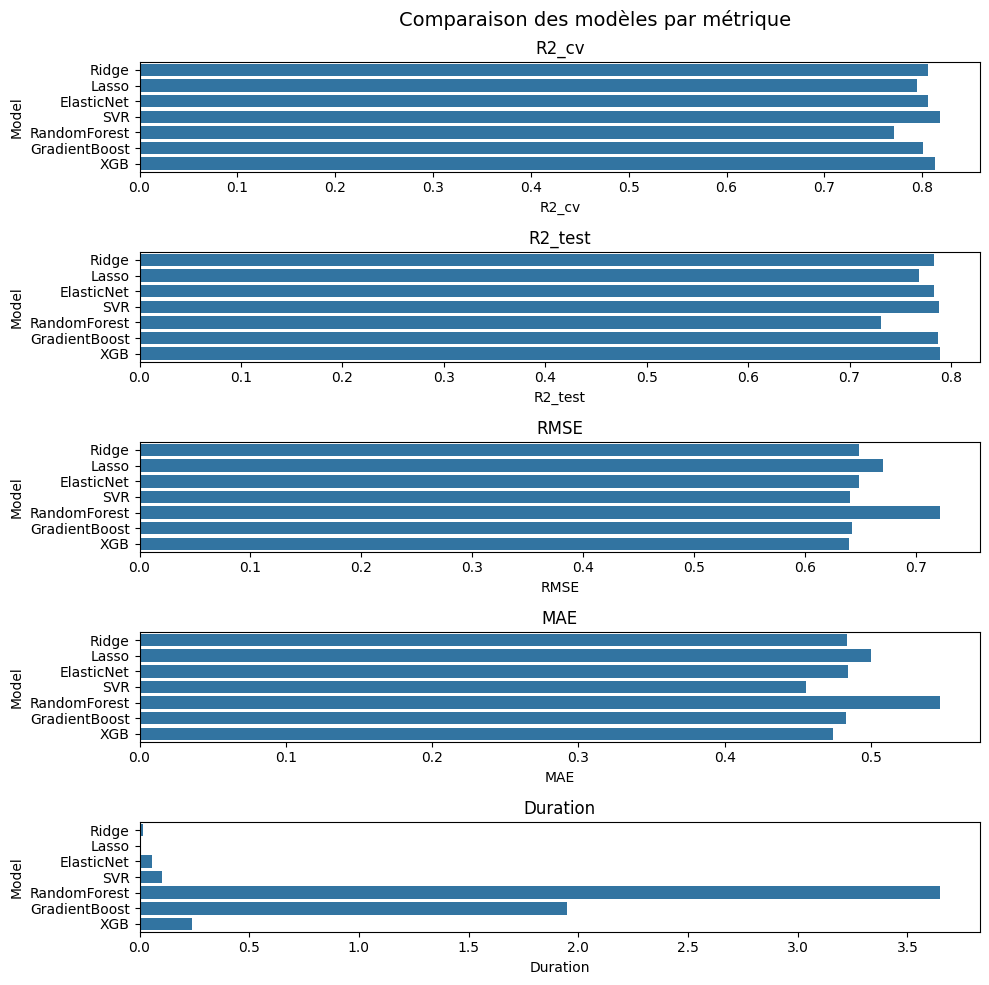

In [184]:
# Visualisation des résultats des différents modèles :

fine_grid_results_df.set_index('Model', inplace=True)

# Création du subplot
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

# Barplot pour R2_cv
sns.barplot(x='R2_cv', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[0])
axs[0].set_title('R2_cv')

# Barplot pour R2_test
sns.barplot(x='R2_test', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[1])
axs[1].set_title('R2_test')

# Barplot pour RMSE
sns.barplot(x='RMSE', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[2])
axs[2].set_title('RMSE')

# Barplot pour MAE
sns.barplot(x='MAE', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[3])
axs[3].set_title('MAE')

# Barplot pour Duration
sns.barplot(x='Duration', y=fine_grid_results_df.index, data=fine_grid_results_df, ax=axs[4])
axs[4].set_title('Duration')

# Ajout d'un titre global
plt.suptitle('Comparaison des modèles par métrique', fontsize=14, x=0.6)

# Ajustements pour un meilleur affichage
plt.tight_layout()
plt.show()

Les performances entre le **SVR** et le **XGBRegressor** sont assez similaires et **notre choix se portera sur ce dernier modèle** pour la suite de l'analyse.

**Visualisation des performances du modèle :**

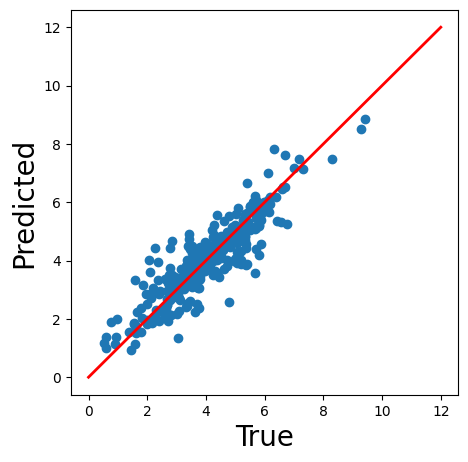

In [185]:
# on récupère les prédictions du modèle XGBRegressor :
pred_test = grid_xgb.predict(X_test_scaled)

# Visualisation/évaluation du modèle
plt.figure(figsize=(5,5))

plt.scatter(y_test_scaled, pred_test)
plt.plot([0, 12],
         [0, 12],
         color = 'r',
         linestyle = '-',
         linewidth = 2)
plt.ylabel('Predicted', size = 20)
plt.xlabel('True', size = 20)

plt.show()

On voit que notre modèle prédit plutôt bien les émissions de GES. Les valeurs prédites sont assez proches des valeurs réelles.

## 9.Feature Importance

### 9.1. Feature Importance globale

#### 9.1.1. Méthode du modèle

In [186]:
xgb_imp = grid_xgb.feature_importances_

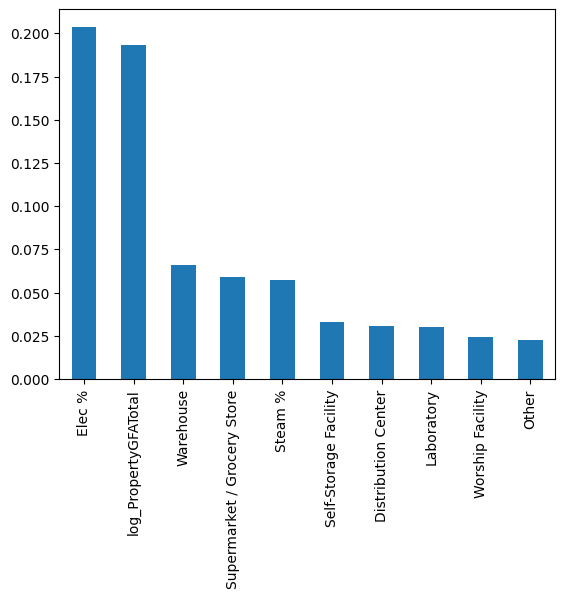

In [187]:
fxgb_importance = pd.Series(xgb_imp, index = X_train_scaled_df.columns).nlargest(10).plot(kind = 'bar')

Via la méthode 'feature_importances_' du modèle XGBRegressor, on peut voir quelles ont été les variables les plus impactantes pour l'entrainement du modèle et pour ses prédictions.
On note ici que les variables "proportion d'électricité utilisée dans le mix énergétique d'un bâtiment" et "surface totale" ont eu un poids bien plus conséquent que les autres variables. Viennent ensuite des types d'usages de bâtiment tels que "Warehouse" et "Supermarket / Grocery Store".
Cependant cette méthode ne nous indique pas dans quel sens ces variables ont influencé la prédiction, ont-elles eu un impact négatif, c'est-à-dire tendant à diminuer la valeur de la prédiction ? Ou positif, c'est à dire tendant à l'augmenter ?

Pour avoir plus de détails sur ces questions nous allons utiliser la librairie SHAP.

#### 9.1.2. SHAP

In [188]:
shap.initjs

<function shap.plots._force.initjs()>

In [189]:
# Get shap values
explainer = shap.Explainer(grid_xgb)
shap_values = explainer(X_test_scaled)

# sample of shape_values : shap_values = explainer(X_test_scaled[0:100])

In [190]:
shap_values.feature_names = X_train_scaled_df.columns

In [191]:
np.shape(shap_values.values)

(325, 33)

In [192]:
features_names = X_train_scaled_df.columns

**Absolute Mean SHAP**

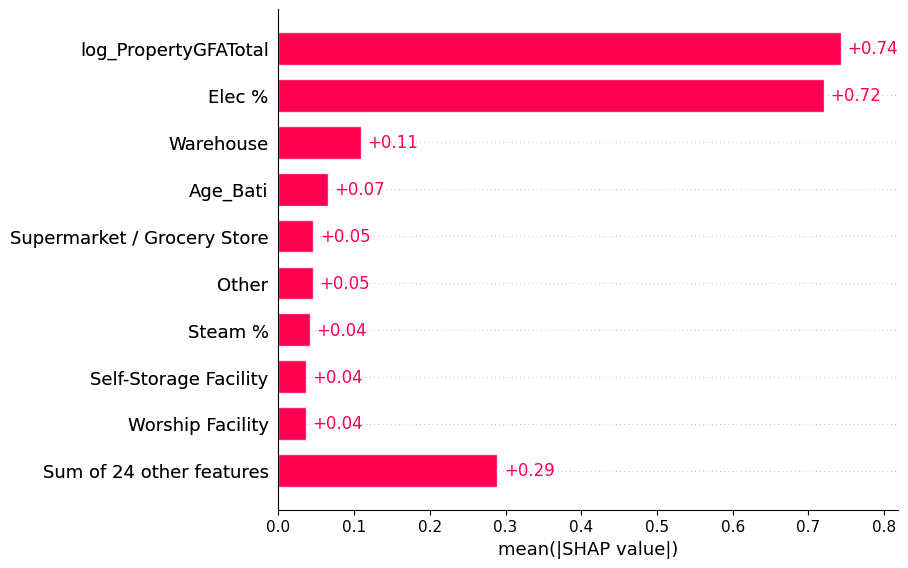

In [193]:
shap.plots.bar(shap_values)

A quelques détails près on retrouve les mêmes variables parmi celles ayant le plus de poids que via l'attribut 'feature_importances_' du modèle.

**Summary plot**

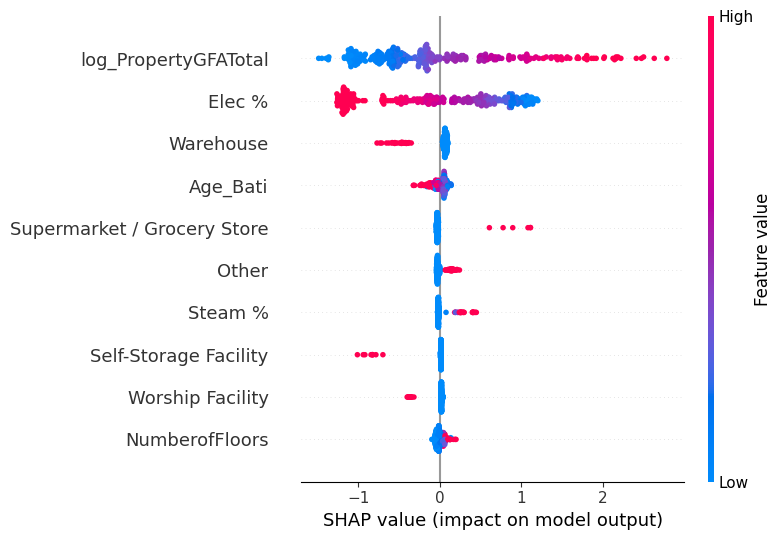

In [194]:
shap.summary_plot(shap_values, max_display=10)

Ce graphique nous permet de déceler les relations existantes entre nos variables et la target.
On voit par exemple que plus les valeurs de la surface, et de 'Steam %' sont grandes, et plus la consommation d'énergie prédite par le modèle est élevée. Il en va de même si le type d'usage est commercial, où pour la catégorie 'Autre'.

A l'inverse on voit que plus la proportion d'électricité utilisée dans le mix énergétique d'un bâtiment est élevée, et plus la consommation d'énergie prédite sera faible. Surprenamment, il en va de même concernant l'âge du bâtiment et le fait qu'il soit de type Entrepôt.

**Dependance Plot**

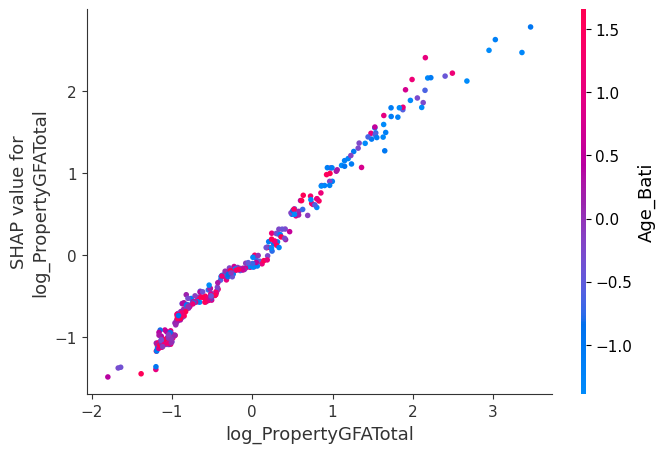

In [195]:
shap.dependence_plot('log_PropertyGFATotal',
                     explainer.shap_values(X_test_scaled),
                     features = X_test_scaled,
                     feature_names = features_names
                     )

### 9.2. Feature Importance locale

Il s'agit ici de montrer le poids de certaines caractéristiques dans les prédictions du modèle pour un individu seulement.

**Bar plot**

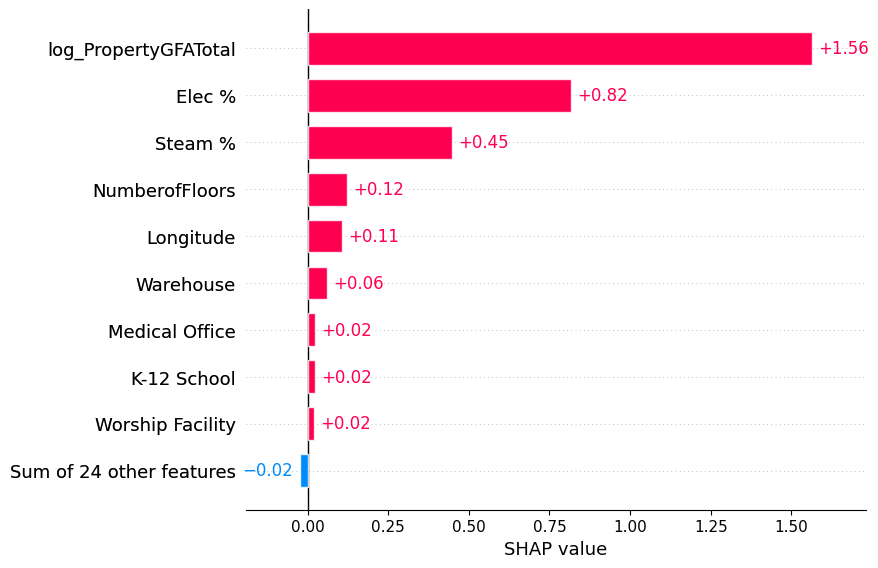

In [196]:
shap.plots.bar(shap_values[50])

Pour l'exemple sélectionné ici, de manière arbitraire, on voit que la surface, et les proportion Elec % et Steam % ont eu une influence positive dans la détermination de la prédiction de consommation totale d'énergie.

**Waterfall plot**

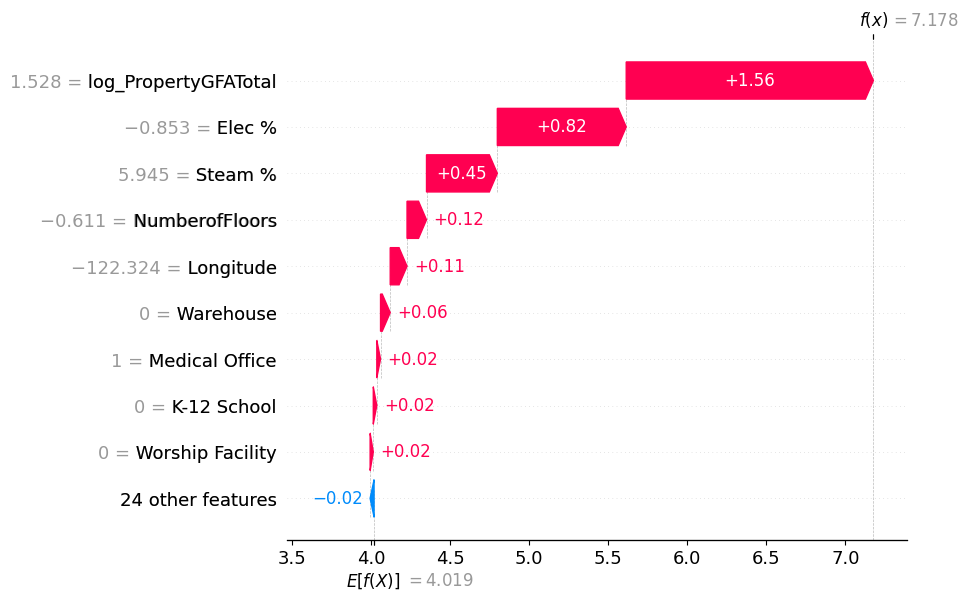

In [197]:
#shap_values.feature_names = X_train_scaled_df.columns
shap.plots.waterfall(shap_values[50])

Avec ce graphique nous en avons une autre visualisation.

**Force plot**

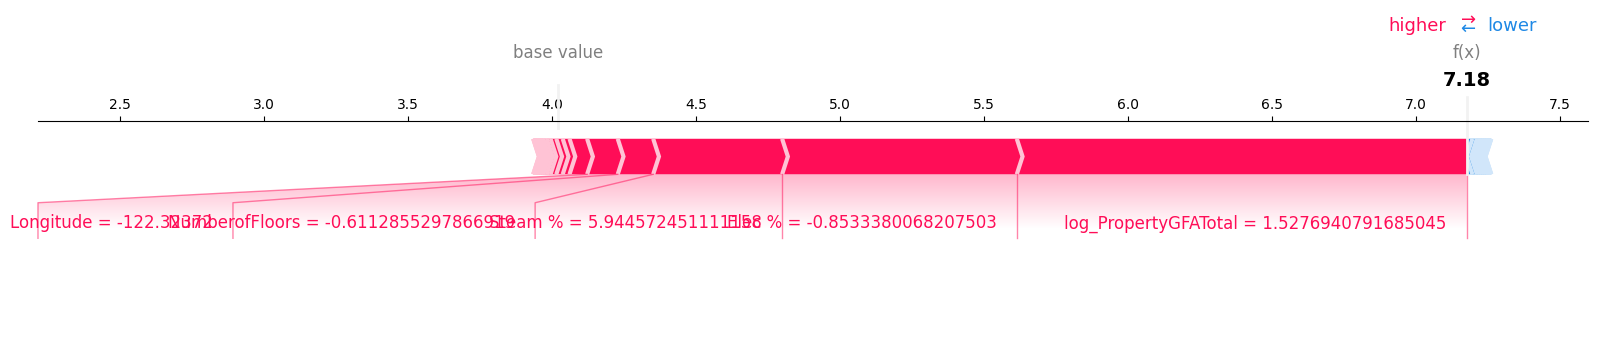

In [198]:
shap.plots.force(shap_values[50],
                 matplotlib = matplotlib)

De même ici.

Prenons un autre exemple :

**Bar plot**

In [199]:
sample_idx = int(np.random.uniform(0, X_test_scaled.shape[0]))

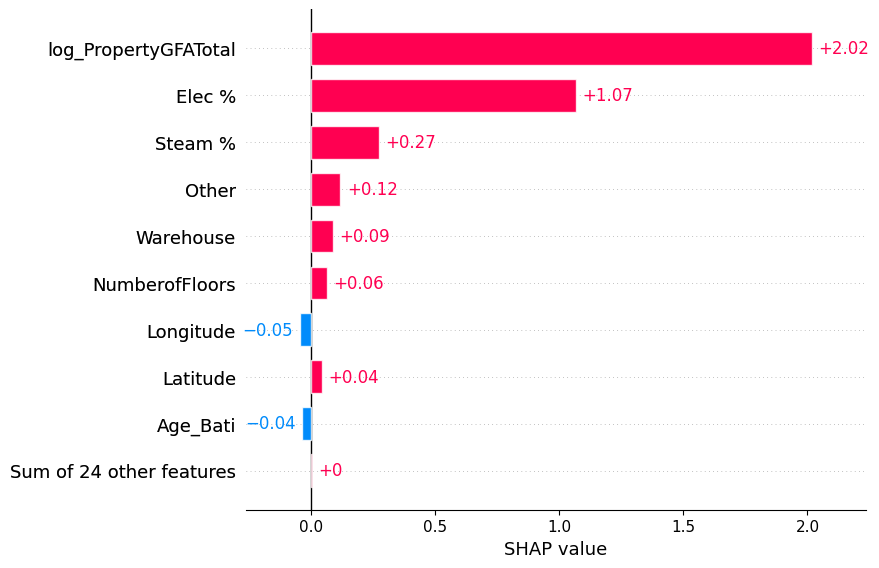

In [200]:
shap.plots.bar(shap_values[sample_idx])

On voit cette fois que la proportion d'utilisation d'électricité dans le mix énergétique a un impact négatif sur la prédiction de la consommation d'énergie.
A l'inverse la surface totale et le nombre d'étages ont un impact positif.

**Waterfall plot**

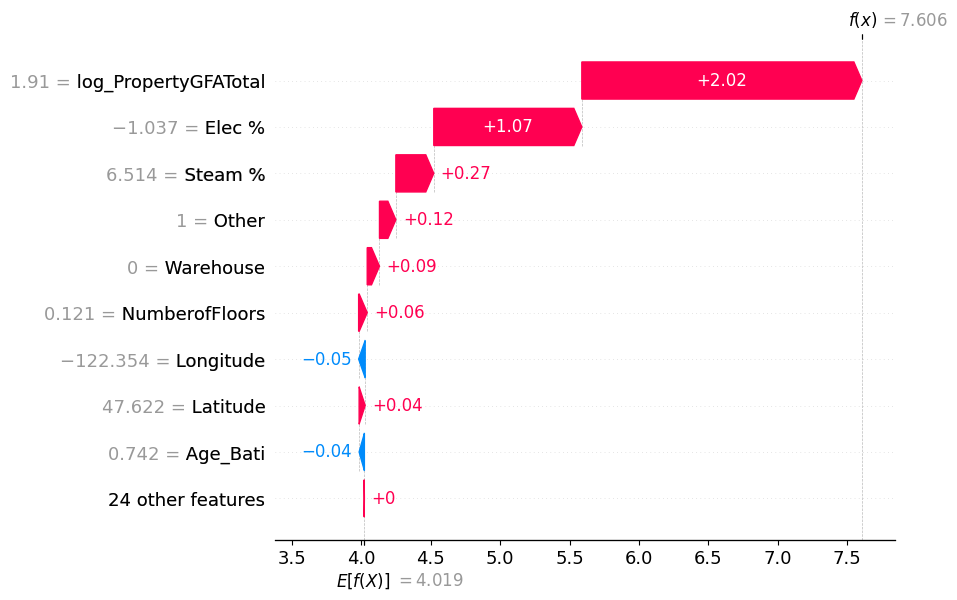

In [201]:
#shap_values.feature_names = X_train_scaled_df.columns
shap.plots.waterfall(shap_values[sample_idx])

Avec ce graphique nous en avons une autre visualisation.

**Force plot**

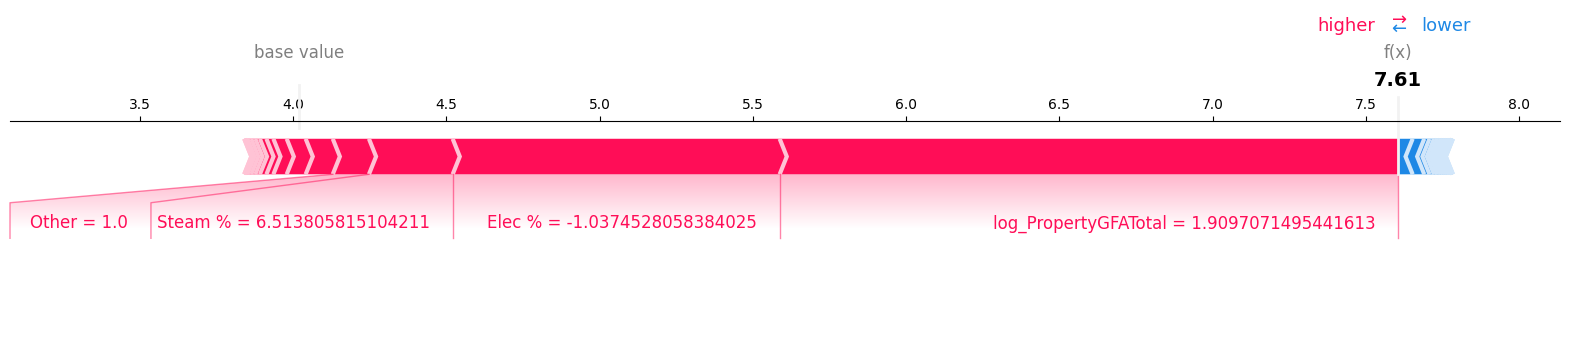

In [202]:
shap.plots.force(shap_values[sample_idx],
                 matplotlib = matplotlib)

## 10.Influence de l'Energy Star Score

### 10.1. Modification du jeu de données

On modifie le jeu de données en conséquences car cette variable a des données manquantes.

In [203]:
data.columns

Index(['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Age_Bati', 'Steam %',
       'Elec %', 'NaturalGas %', 'UseTypesNumber', 'Surf_1er_type_prop',
       'Surf_2e_type_prop', 'Surf_3e_type_prop', 'Surf_batie_prop',
       'Surf_parking_prop', 'log_PropertyGFATotal'],
      dtype='object')

In [204]:
data_2 = data[~data['ENERGYSTARScore'].isna()]
data_2.isna().mean()

PrimaryPropertyType               0.0000
Latitude                          0.0000
Longitude                         0.0000
NumberofBuildings                 0.0000
NumberofFloors                    0.0000
PropertyGFATotal                  0.0000
PropertyGFAParking                0.0000
PropertyGFABuilding(s)            0.0000
ListOfAllPropertyUseTypes         0.0000
SecondLargestPropertyUseTypeGFA   0.5378
ENERGYSTARScore                   0.0000
SiteEnergyUse(kBtu)               0.0000
TotalGHGEmissions                 0.0000
Age_Bati                          0.0000
Steam %                           0.0000
Elec %                            0.0000
NaturalGas %                      0.0000
UseTypesNumber                    0.0000
Surf_1er_type_prop                0.0000
Surf_2e_type_prop                 0.0000
Surf_3e_type_prop                 0.0000
Surf_batie_prop                   0.0000
Surf_parking_prop                 0.0000
log_PropertyGFATotal              0.0000
dtype: float64

**Préparation des données**

In [205]:
# Etablissement de plusieurs choix de variables explicatives :

var_exp_sansess = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

numerical_features_sansess = ['NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop']

categorical_features = ['PrimaryPropertyType']

var_exp_avecess = ['PrimaryPropertyType', 'Latitude', 'Longitude', 'NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop', 'ENERGYSTARScore']

numerical_features_avecess = ['NumberofFloors', 'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %', 'UseTypesNumber',
           'Surf_batie_prop', 'Surf_parking_prop', 'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop', 'ENERGYSTARScore']

On utilisera donc notre transformation StandardScaler() pour les données numériques et un OneHotEncoder sur le type d'usage de bâtiment.

In [206]:
# Pour les variables explicatives :
stand_transformer_sansess = make_column_transformer((OneHotEncoder(), categorical_features), (StandardScaler(), numerical_features_sansess), remainder='passthrough')
stand_transformer_avecess = make_column_transformer((OneHotEncoder(), categorical_features), (StandardScaler(), numerical_features_avecess), remainder='passthrough')

# Pour la variable cible :
target_transfo = FunctionTransformer(func = np.log1p, inverse_func = np.expm1)

### 10.2. Entrainement du modèle sans l'Energy Star Score

Je sépare mes variables entre variables explicatives (exogènes) d'un coté et expliquée (endogène) de l'autre :

In [207]:
X = data_2[var_exp_sansess]
y = data_2['TotalGHGEmissions']

Puis je crée des jeux de données d'entrainement et de test :

In [208]:
# split des données :

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=30)

**Transformation des données :**

In [209]:
# Je transforme les données explicatives :
X_train_scaled = stand_transformer_sansess.fit_transform(X_train)
X_test_scaled = stand_transformer_sansess.transform(X_test)

# Et cible :
y_train_scaled = target_transfo.fit_transform(y_train)
y_test_scaled = target_transfo.transform(y_test)

Création d'un DF Xtrain_scaled pour l'analyse de feature

In [210]:
# Pour les features importances on récupères les noms de colonnes de nos jeu de données :
feature_names_encoded = stand_transformer_sansess.get_feature_names_out(X_train.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = feature_names_encoded)
X_train_scaled_df.rename(columns=lambda x: x.replace('onehotencoder__PrimaryPropertyType_', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('standardscaler__', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('remainder__', ''), inplace=True)

On entraine le modèle et affiche ses résultats :

In [211]:
xgb_sansess = XGBRegressor(gamma = 0.3, learning_rate = 0.03, max_depth = 3, min_child_weight = 5, n_estimators = 500, subsample = 0.7, random_state = 42)
start_time = time.time()
xgb_sansess.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [212]:
# cross val score :
r2_cv = cross_val(xgb_sansess, X_train_scaled, y_train_scaled)

In [213]:
pred_train = xgb_sansess.predict(X_train_scaled)
pred_test = xgb_sansess.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.2797609226967751 		 MAE test: 0.3825445193933288
MSE train: 0.144745722266275 		 MSE test: 0.29054666551887326
RMSE train: 0.38045462576537953 		 RMSE test: 0.5390238079332612
R2 train: 0.923615263577114 		 R2 test: 0.8770477319124634
__________________________________


In [214]:
# On récupère les résultats dans un Dataframe :
xgb_sansess_results_df = pd.DataFrame(data=[["XGB_sansess", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])

display(xgb_sansess_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,XGB_sansess,0.3825,0.5390,0.8770,0.9236,0.8298,0.2379


On voit qu'on a des résultats sensiblement meilleurs que ceux du modèle précédent. On a même un peu moins d'overfitting ici même s'il est toujours présent.
Visualisation l'adéquation de nos données prédites avec les valeurs réelles :

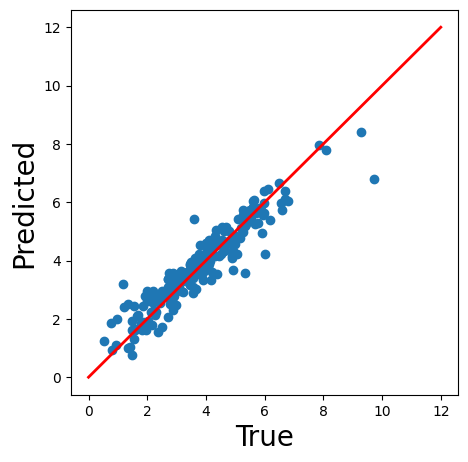

In [215]:
# Visualisation/évaluation du modèle
plt.figure(figsize=(5,5))

plt.scatter(y_test_scaled, pred_test)
plt.plot([0, 12],
         [0, 12],
         color = 'r',
         linestyle = '-',
         linewidth = 2)
plt.ylabel('Predicted', size = 20)
plt.xlabel('True', size = 20)

plt.show()

On voit en effet que le modèle prédit plutôt bien les émissions de GES et est assez proche des valeurs réelles.

#### Feature Importance

**Feature Importance globale**

**Méthode du modèle**

In [216]:
xgb_sansess_imp = xgb_sansess.feature_importances_

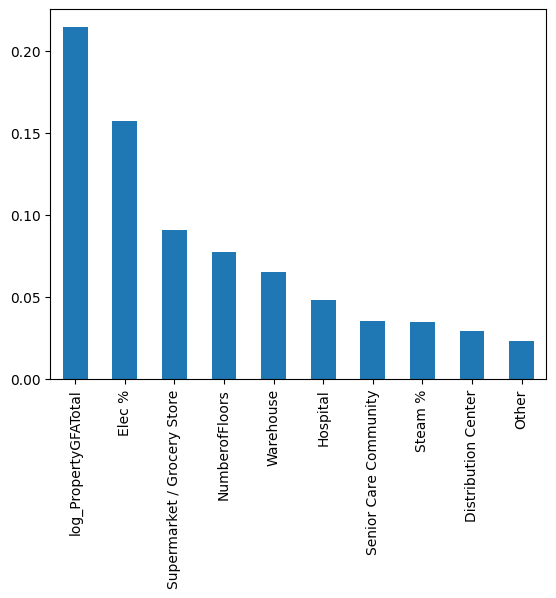

In [217]:
fxgb_sansess_importance = pd.Series(xgb_sansess_imp, index = X_train_scaled_df.columns).nlargest(10).plot(kind = 'bar')

On retrouve les 2 mêmes variables ayant apporté le plus de contribution à la prédiction. On note quelques changements pour les autres.

**SHAP**

In [218]:
# Get shap values
explainer = shap.Explainer(xgb_sansess)
shap_values = explainer(X_test_scaled)

# sample of shape_values : shap_values = explainer(X_test_scaled[0:100])

In [219]:
np.shape(shap_values.values)

(215, 29)

In [220]:
shap_values.feature_names = X_train_scaled_df.columns

In [221]:
features_names = X_train_scaled_df.columns

Absolute Mean SHAP

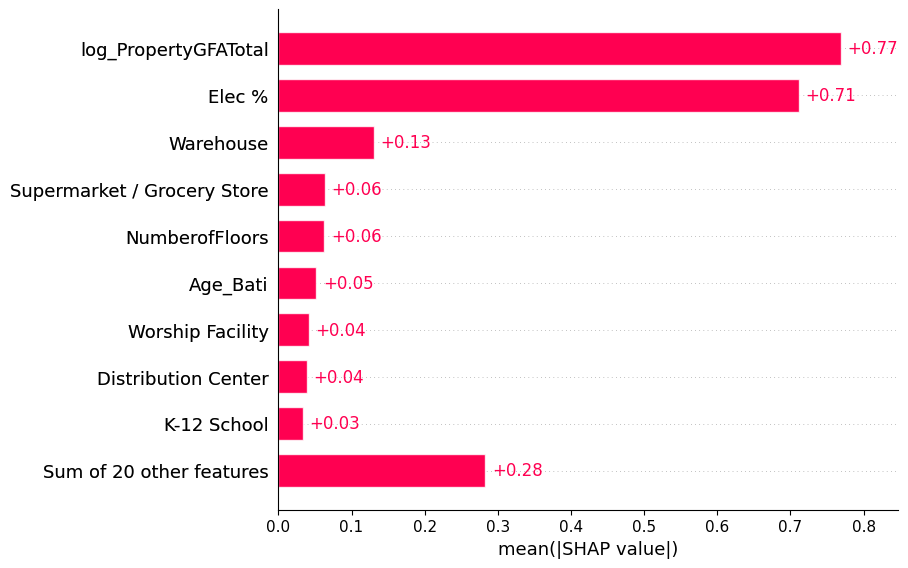

In [222]:
shap.plots.bar(shap_values)

Summary plot

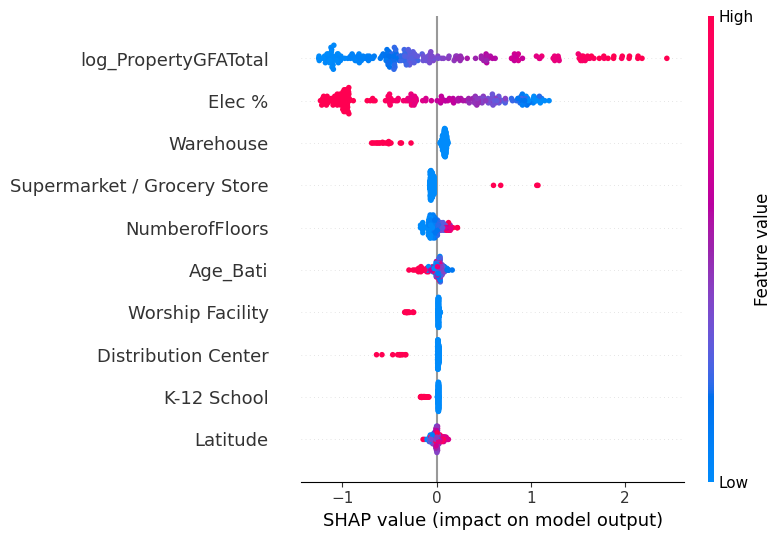

In [223]:
shap.summary_plot(shap_values, max_display=10)

On peut ici faire les mêmes commentaires que précédemment.

Dependance Plot

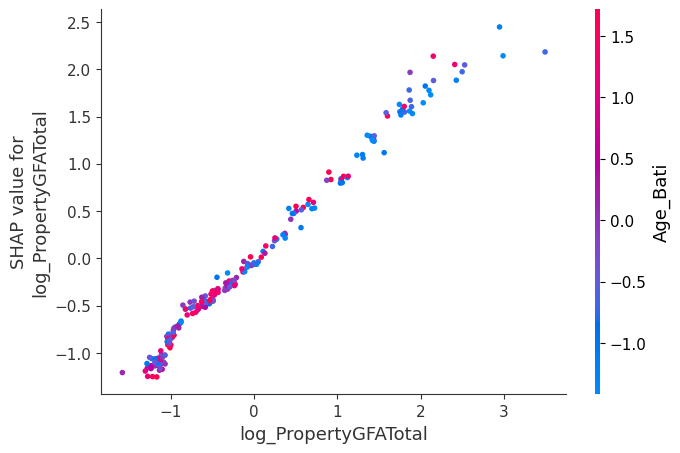

In [224]:
shap.dependence_plot('log_PropertyGFATotal',
                     explainer.shap_values(X_test_scaled),
                     features = X_test_scaled,
                     interaction_index="Age_Bati",
                     feature_names = features_names
                     )

**Feature Importance locale**

Il s'agit ici de montrer le poids de certaines caractéristiques dans les prédictions du modèle pour un individu seulement.

Bar plot

In [225]:
sample_idx = int(np.random.uniform(0, X_test_scaled.shape[0]))

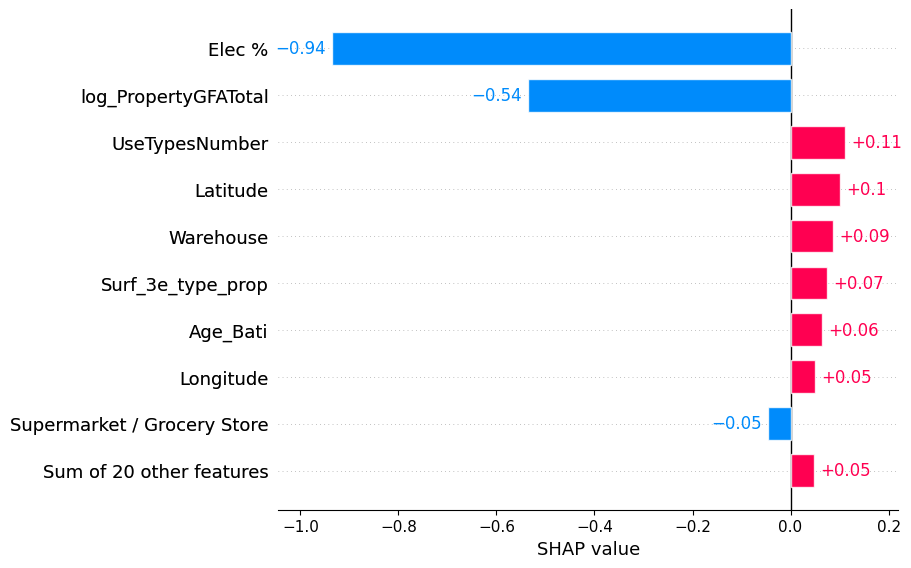

In [226]:
shap.plots.bar(shap_values[sample_idx])

On voit cette fois que la surface totale a un impact négatif sur la prédiction de la consommation d'énergie, de même que la proportion d'utilisation d'électricité dans le mix énergétique.

Waterfall plot

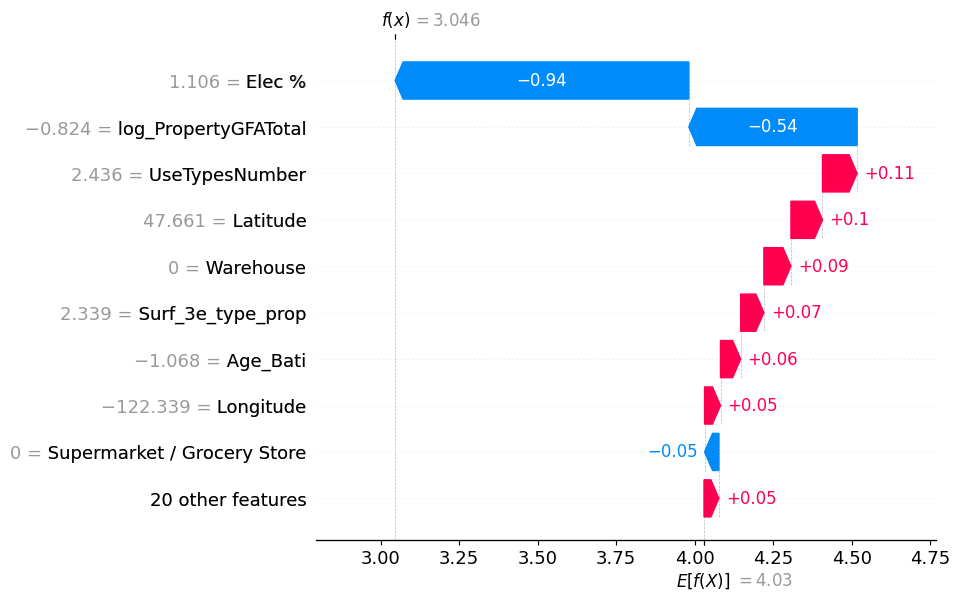

In [227]:
shap.plots.waterfall(shap_values[sample_idx])

Avec ce graphique nous en avons une autre visualisation.

Force plot

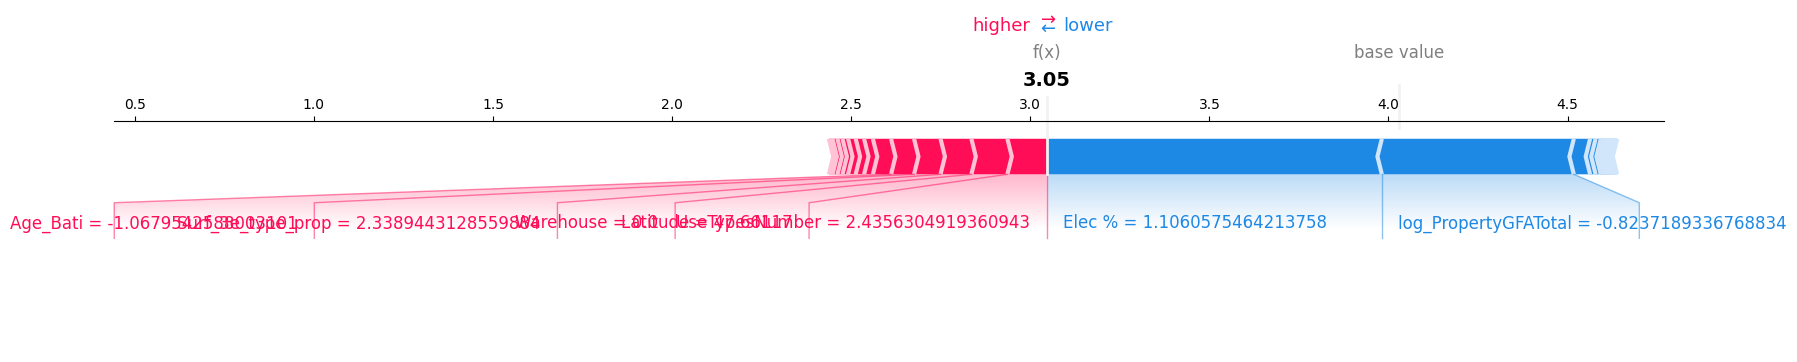

In [228]:
shap.plots.force(shap_values[sample_idx],
                 matplotlib = matplotlib)

### 10.3. Intégration de l'Energy Star Score

Je sépare mes variables entre variables explicatives (exogènes) d'un coté et expliquée (endogène) de l'autre :

In [229]:
X = data_2[var_exp_avecess]
y = data_2['TotalGHGEmissions']

Puis je crée des jeux de données d'entrainement et de test :

In [230]:
# split des données :

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=30)

**Transformation des données :**

In [231]:
# Je transforme les données explicatives :
X_train_scaled = stand_transformer_avecess.fit_transform(X_train)
X_test_scaled = stand_transformer_avecess.transform(X_test)

# Et cible :
y_train_scaled = target_transfo.fit_transform(y_train)
y_test_scaled = target_transfo.transform(y_test)

Création d'un DF Xtrain_scaled pour l'analyse de feature

In [232]:
# Pour les features importances on récupères les noms de colonnes de nos jeu de données :
feature_names_encoded = stand_transformer_avecess.get_feature_names_out(X_train.columns)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = feature_names_encoded)
X_train_scaled_df.rename(columns=lambda x: x.replace('onehotencoder__PrimaryPropertyType_', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('standardscaler__', ''), inplace=True)
X_train_scaled_df.rename(columns=lambda x: x.replace('remainder__', ''), inplace=True)

On entraine le modèle et affiche ses résultats :

In [233]:
xgb_avecess = XGBRegressor(gamma = 0.3, learning_rate = 0.03, max_depth = 3, min_child_weight = 5, n_estimators = 500, subsample = 0.7, random_state = 42)
start_time = time.time()
xgb_avecess.fit(X_train_scaled, y_train_scaled)
elapsed = time.time() - start_time

In [234]:
# cross val score :
r2_cv = cross_val(xgb_avecess, X_train_scaled, y_train_scaled)

In [235]:
pred_train = xgb_avecess.predict(X_train_scaled)
pred_test = xgb_avecess.predict(X_test_scaled)
# Affichage des résultats :
print_evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train)

MAE train: 0.20188881354453753 		 MAE test: 0.29657880696159417
MSE train: 0.07564634383948907 		 MSE test: 0.17601934747527131
RMSE train: 0.2750388042431269 		 RMSE test: 0.4195465975017213
R2 train: 0.9600801602626658 		 R2 test: 0.9255129018234526
__________________________________


In [236]:
# On récupère les résultats dans un Dataframe :
xgb_avecess_results_df = pd.DataFrame(data=[["XGB_avecess", *evaluate(y_test_scaled, pred_test, y_train_scaled, pred_train) , r2_cv, elapsed]],
                          columns=['Model', 'MAE', 'RMSE', 'R2_test',"R2_train", "R2_cv", "Duration"])

display(xgb_avecess_results_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,XGB_avecess,0.2966,0.4195,0.9255,0.9601,0.9004,1.3893


L'intégration de l'Energy Star Score améliore les résultats du modèle mais on a encore une fois une hausse de l'overfitting. Peut-être est-on là aussi en présence de data leackage, le score de cette variable étant lié aux performances énergétiques des bâtiments, elles mêmes liées à leurs émissions de Gaz à effet de serre.

Comparaison des scores sans et avec l'Energy Star Score :

In [237]:
comp_df = pd.concat([xgb_sansess_results_df, xgb_avecess_results_df], ignore_index = True)
display(comp_df)

,Model,MAE,RMSE,R2_test,R2_train,R2_cv,Duration
0,XGB_sansess,0.3825,0.5390,0.8770,0.9236,0.8298,0.2379
1,XGB_avecess,0.2966,0.4195,0.9255,0.9601,0.9004,1.3893


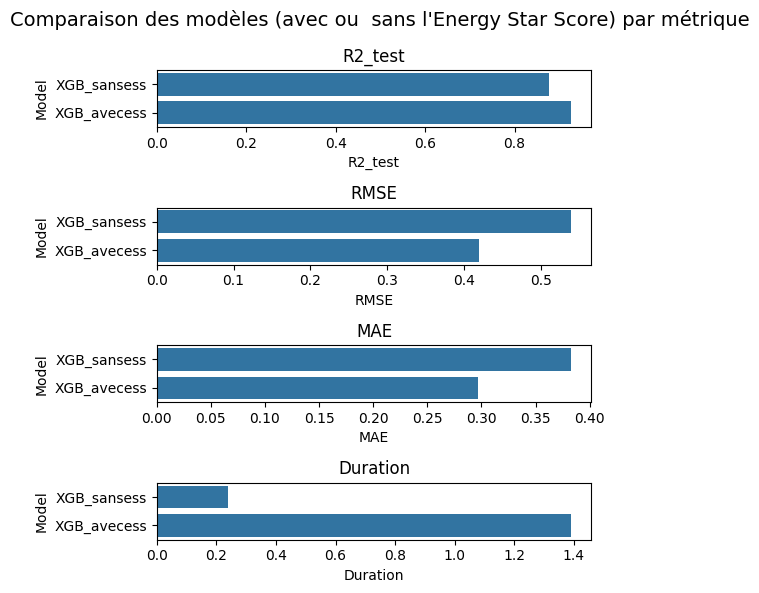

In [238]:
# Visualisation des résultats des différents modèles :

comp_df.set_index('Model', inplace=True)

# Création du subplot
fig, axs = plt.subplots(4, 1, figsize=(6, 6))

# Barplot pour R2_test
sns.barplot(x='R2_test', y=comp_df.index, data=comp_df, ax=axs[0])
axs[0].set_title('R2_test')

# Barplot pour RMSE
sns.barplot(x='RMSE', y=comp_df.index, data=comp_df, ax=axs[1])
axs[1].set_title('RMSE')

# Barplot pour MAE
sns.barplot(x='MAE', y=comp_df.index, data=comp_df, ax=axs[2])
axs[2].set_title('MAE')

# Barplot pour Duration
sns.barplot(x='Duration', y=comp_df.index, data=comp_df, ax=axs[3])
axs[3].set_title('Duration')

# Ajout d'un titre global
plt.suptitle("Comparaison des modèles (avec ou  sans l'Energy Star Score) par métrique", fontsize=14, x=0.6)

# Ajustements pour un meilleur affichage
plt.tight_layout()
plt.show()

Visualisation l'adéquation de nos données prédites avec les valeurs réelles :

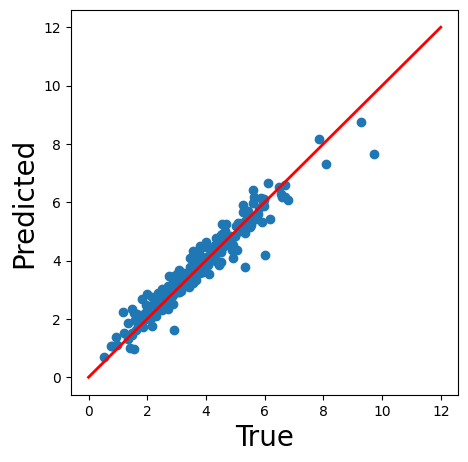

In [239]:
# Visualisation/évaluation du modèle
plt.figure(figsize=(5,5))

plt.scatter(y_test_scaled, pred_test)
plt.plot([0, 12],
         [0, 12],
         color = 'r',
         linestyle = '-',
         linewidth = 2)
plt.ylabel('Predicted', size = 20)
plt.xlabel('True', size = 20)

plt.show()

On voit en effet que le modèle prédit plutôt bien les émissions de GES et est assez proche des valeurs réelles.

#### Feature Importance

**Feature Importance globale**

**Méthode du modèle**

In [240]:
xgb_avecess_imp = xgb_avecess.feature_importances_

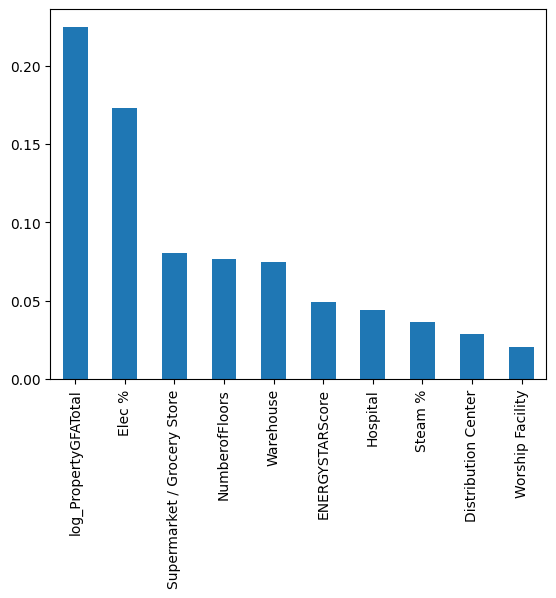

In [241]:
fxgb_avecess_importance = pd.Series(xgb_avecess_imp, index = X_train_scaled_df.columns).nlargest(10).plot(kind = 'bar')

La variable 'Energy Star Score' fait partie des 10 variables les plus importantes dans la détermination de la prédiction. Cependant son poids ne semble pas très conséquent et est assez loin de ceux de la surface totale et du nombre d'étages.

**SHAP**

In [242]:
# Get shap values
explainer = shap.Explainer(xgb_avecess)
shap_values = explainer(X_test_scaled)

# sample of shape_values : shap_values = explainer(X_test_scaled[0:100])

In [243]:
np.shape(shap_values.values)

(215, 30)

In [244]:
shap_values.feature_names = X_train_scaled_df.columns

In [245]:
X_train_scaled_df.columns

Index(['Distribution Center', 'Hospital', 'Hotel', 'K-12 School',
       'Large Office', 'Medical Office', 'Mixed Use Property', 'Other',
       'Refrigerated Warehouse', 'Retail Store', 'Senior Care Community',
       'Small- and Mid-Sized Office', 'Supermarket / Grocery Store',
       'Warehouse', 'Worship Facility', 'NumberofFloors',
       'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %',
       'UseTypesNumber', 'Surf_batie_prop', 'Surf_parking_prop',
       'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop',
       'ENERGYSTARScore', 'Latitude', 'Longitude'],
      dtype='object')

In [246]:
features_names = X_train_scaled_df.columns

**Absolute Mean SHAP**

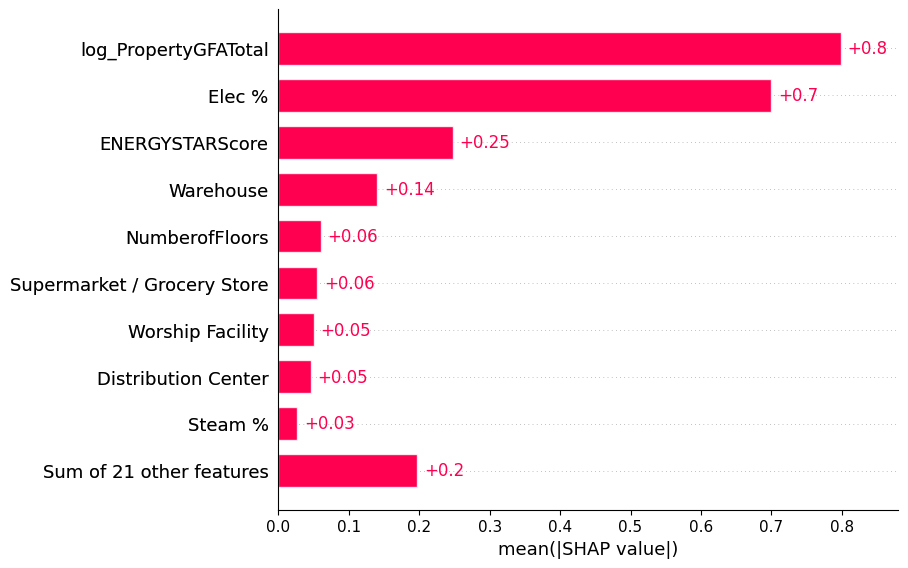

In [247]:
shap.plots.bar(shap_values)

L'utilisation du package SHAP semble montrer que l'Energy Star Score a une importance tout de même assez élevée, se plaçant en 3e position derrière la surface totale et 'Elec %'.

**Summary plot**

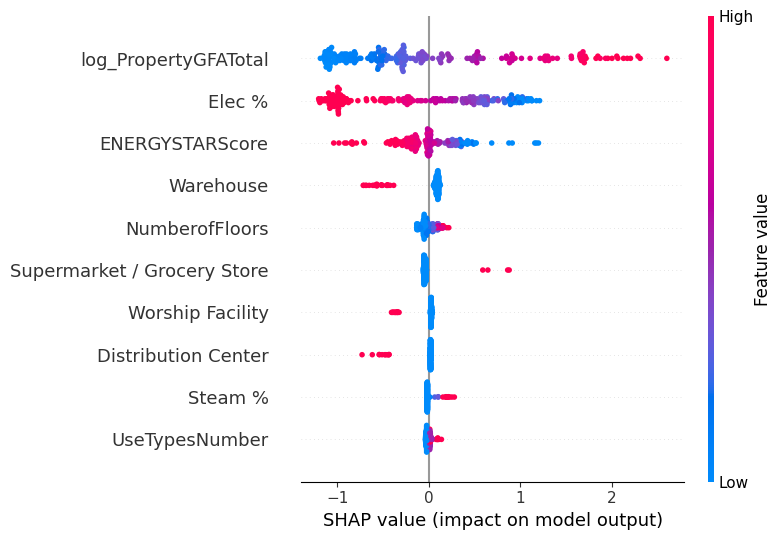

In [248]:
shap.summary_plot(shap_values, max_display=10)

La relation entre notre variable cible et l'Energy Star Score est négative, ce qui semble logique dans la mesure où plus le score de cet indicateur est élevé et plus on est censé avoir une consommation d'énergie raisonnable et donc a priori des émissions de GES allant dans le même sens.

**Dependance Plot**

In [249]:
features_names

Index(['Distribution Center', 'Hospital', 'Hotel', 'K-12 School',
       'Large Office', 'Medical Office', 'Mixed Use Property', 'Other',
       'Refrigerated Warehouse', 'Retail Store', 'Senior Care Community',
       'Small- and Mid-Sized Office', 'Supermarket / Grocery Store',
       'Warehouse', 'Worship Facility', 'NumberofFloors',
       'log_PropertyGFATotal', 'Age_Bati', 'Steam %', 'Elec %', 'NaturalGas %',
       'UseTypesNumber', 'Surf_batie_prop', 'Surf_parking_prop',
       'Surf_1er_type_prop', 'Surf_2e_type_prop', 'Surf_3e_type_prop',
       'ENERGYSTARScore', 'Latitude', 'Longitude'],
      dtype='object')

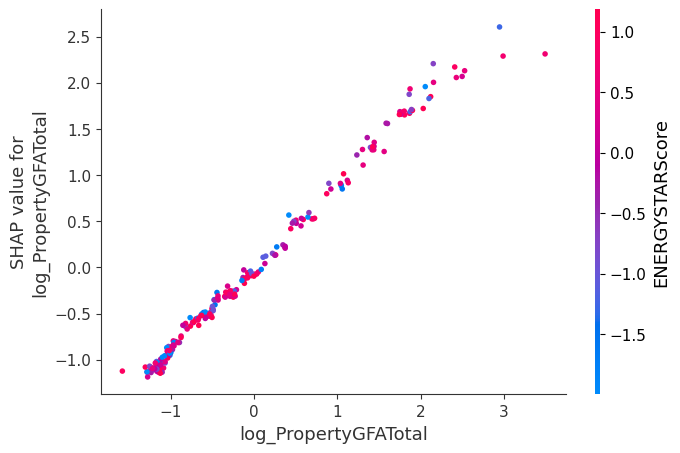

In [250]:
shap.dependence_plot('log_PropertyGFATotal',
                     explainer.shap_values(X_test_scaled),
                     features = X_test_scaled,
                     interaction_index = 'ENERGYSTARScore',
                     feature_names = features_names
                     )

**Feature Importance locale**

Il s'agit ici de montrer le poids de certaines caractéristiques dans les prédictions du modèle pour un individu seulement.

**Bar plot**

In [251]:
sample_idx = int(np.random.uniform(0, X_test_scaled.shape[0]))

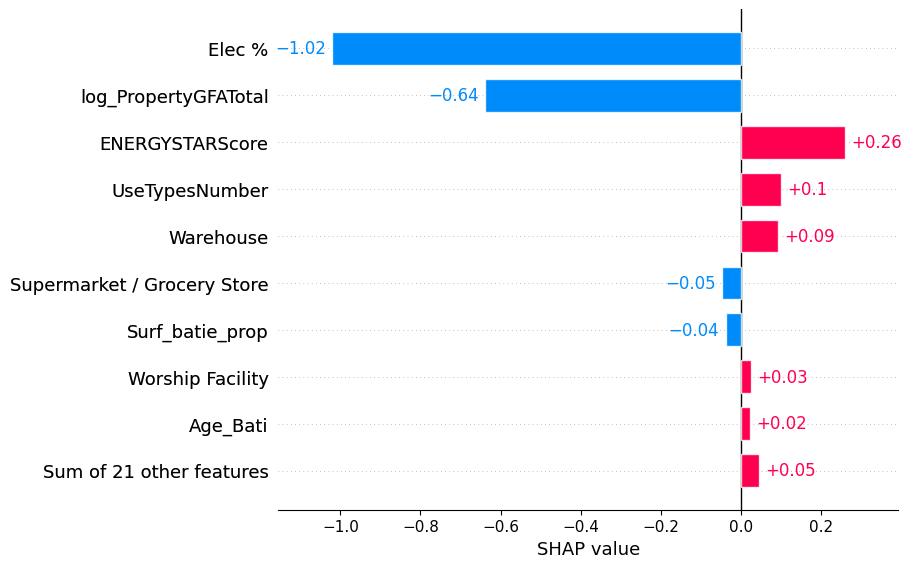

In [252]:
shap.plots.bar(shap_values[sample_idx])

On voit cette fois que la surface totale a un impact négatif sur les émissions de GES, de même que Elec %. On a la relation inverse pour l'Energy Star Score. On a probalement ici à faire à un bâtiment ayant une surface plutôt faible comparé aux autres mais ayant également un Energy Star Score assez faible.

**Waterfall plot**

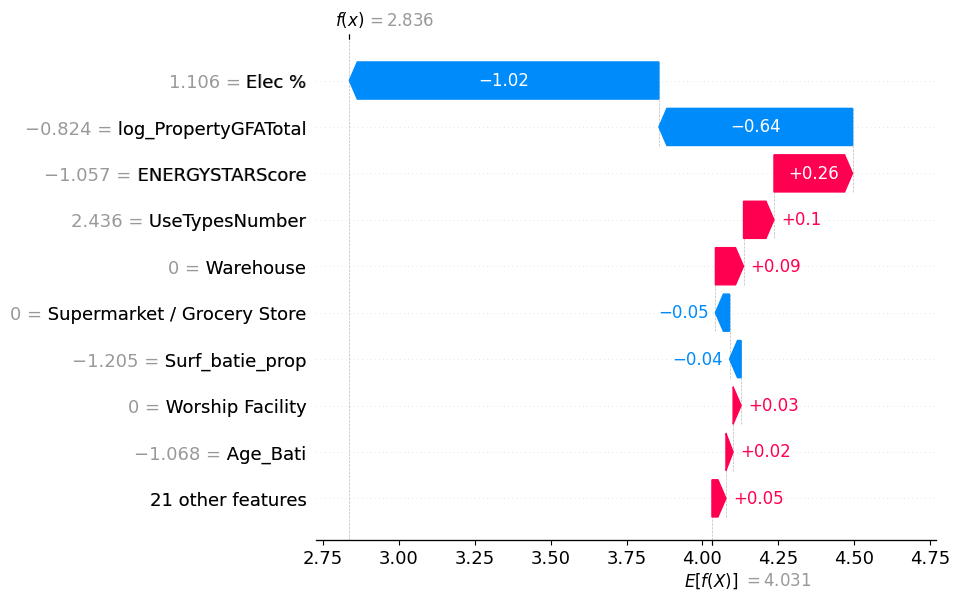

In [253]:
#shap_values.feature_names = X_train_scaled_df.columns
shap.plots.waterfall(shap_values[sample_idx])

Avec ce graphique nous en avons une autre visualisation.

**Force plot**

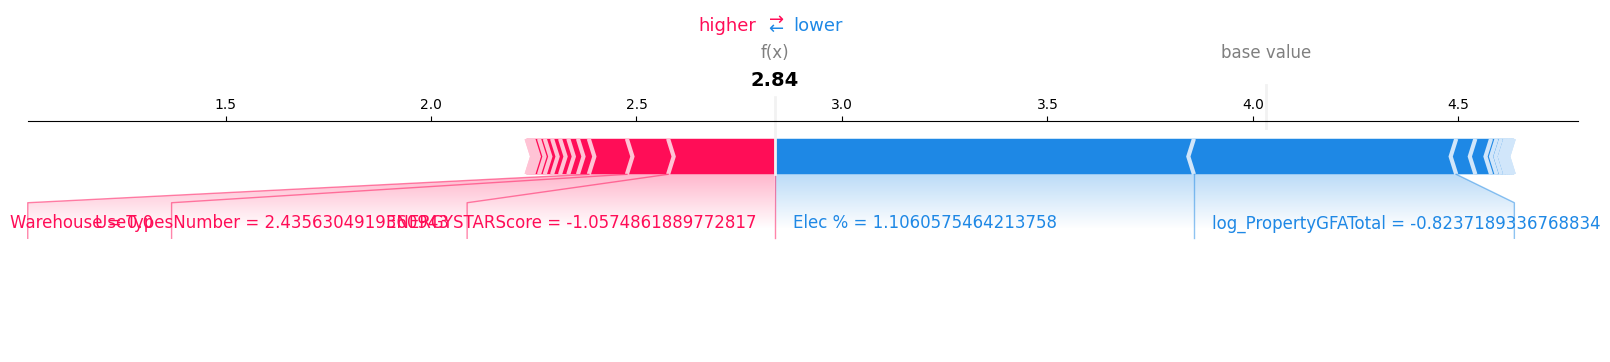

In [254]:
shap.plots.force(shap_values[sample_idx],
                 matplotlib = matplotlib)